In [1]:
import os
import numpy as np
import tensorflow as tf
import time
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from pandas_datareader import data,wb
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

/home/user/anaconda3/envs/tf/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
class StockData():
    """
        훈련용 데이터세트와 평가용 데이터세트를 만들기 위한 과정.

        파라미터:
            folderPath : 종목시장의 주가 csv가 저장되어있는 디렉토리 경로.
            indexPath : 종목시장의 인덱스 주 csv파일의 경로.
            timewindowsize : LSTM의 입력으로 들어가는 타임의 사이즈. 10일 경우 미래주가를 예측하기 위해 이전 10일 주가를 사용.
            windowsizeForPCC : PCC를 계산하기 위해 사용되는 타임의 사이즈. 10일 경우 관계주를 구하기 위해 이전 10일 주가를 사용.
            PositiveStockNumber : 긍정관계주 개수.
            NegativeStockNumber : 부정관계주 개수.
            train_test_rate : 훈련:평가 세트 비율. 0.7일 경우 생성된 데이터 세트중 70%는 훈련용, 30%는 평가용으로 사용.
            batchSize : 세트를 나누는 배치 사이즈.

        과정:
            종목시장의 모든 종목의 시가와 인덱스 시가를 읽어옴.
            minmax스케일러를 각 종목과 인덱스에 적용하고 저장.
            PCC계산, 관계주 계산.
            데이터세트 저장.
               
    """
    def __init__(self,folderPath,indexPath,timewindowsize,windowsizeForPCC,PostiveStockNumber,NegativeStockNumber,train_test_rate,batchSize):        
               
        if(train_test_rate<=0 or train_test_rate>=1):
            raise ValueError('train_test_rate should be between 0 and 1')        
        self.P=PostiveStockNumber
        self.N=NegativeStockNumber        
        self.T=timewindowsize
        self.Tr=windowsizeForPCC
        self.folderPath = folderPath      
        self.indexPath=indexPath    
        self.batchSize=batchSize
        self.date_duration=3000
        
        self.train_test_rate=train_test_rate
        self.scaler=MinMaxScaler(feature_range=(-1,1))  
        self.indexScaler = MinMaxScaler(feature_range=(-1,1))

        self.indexPrice = self.loadIndex()
        self.stockPrice = self.loadCSV()

        self.trainSet,self.testSet=self.make_dataset()

        self.batchNum={}
    
    def getBatch(self,option):
        """
        클래스에 저장된 세트를 y,xp,xn,xi,target으로 나누고 batch생성.

        args:
            option='training' or 'evaluation'

        returns:
            batch 제너레이터
            batch={'y','xp','xn','xi','target'}
        """
        if(option is not 'training' and option is not 'evaluation'):
            raise ValueError('option should be "training" or "evaluation".')

        if(option is 'training'):
            returnSet = self.trainSet
        else:
            returnSet = self.testSet
        
        y=[]
        xp=[]
        xn=[]
        xi=[]
        target=[]

        for d in returnSet:
            y.append(d['target_history'])  
            xp.append(d['pos_history'])       
            xn.append(d['neg_history'])       
            xi.append(d['index_history'])       
            target.append(d['target_price'])             
        y=np.reshape(y,(-1,self.T,1))
        xp=np.reshape(xp,(-1,10,self.T,1))
        xn=np.reshape(xn,(-1,10,self.T,1))
        xi=np.reshape(xi,(-1,self.T,1))
        target=np.reshape(target,(-1,1))

        print(y.shape,xp.shape,xn.shape,xi.shape,target.shape)     

        batchNum=int(len(y)/self.batchSize)
        self.batchNum[option]=batchNum

        for i in range(batchNum):
            yield {'y':y[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xp':xp[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xn':xn[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xi':xi[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'target':target[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32)}

    def loadCSV(self):
        """
        csv파일이 있는 폴더를 입력으로 받아 데이터를 읽어옴.
        """
        csvList=os.listdir(self.folderPath)        
        dataframe = pd.DataFrame([])
        

        for csv in csvList:
            data=pd.read_csv(self.folderPath+'/'+csv,engine='python')
            if(len(data)>self.date_duration):
                data=data[-self.date_duration-1:-1]
                data=data.reset_index()
                data=data['open']

                dataframe=dataframe.append(data,ignore_index=True)
        dataT=np.array(dataframe).T
        self.scaler.fit(dataT)
        dataT=self.scaler.transform(dataT)
        dataT=dataT.T
        dataframe=pd.DataFrame(dataT)
        dataframe=dataframe.transpose()
        print('StockPrice shape: ',dataframe.shape)
        return dataframe
    
    def loadIndex(self):
        data=pd.read_csv(self.indexPath,engine='python')
        data=data[-self.date_duration-1:-1]        
        data=data.reset_index()
        data=data.fillna(method='ffill')

        data=np.array(data['Open'])
        data=np.reshape(data,(-1,1))

        data=self.indexScaler.fit_transform(data)

        data=pd.DataFrame(np.squeeze(data))        

        print('IndexPrice shape: ',data.shape)
        return data 


    def make_dataset(self):
        """
        예측모델에 사용되는 입력,타겟 데이터세트.
        입력데이터의 shape는 (목표주식+관계주식+인덱스, 타임윈도우사이즈)
        타겟데이터의 shape는 (1,1)
        """
        maxday=max([self.T,self.Tr])
        dataset=[]

        for i in range(maxday,len(self.stockPrice)):
            print('making dataset progress : {}/{}'.format(i,len(self.stockPrice)),end='\r')
            priceSet=self.stockPrice.loc[i-self.T:i-1]
            targetSet=self.stockPrice.loc[i]
            positiveSet,negativeSet=self.calculate_correlation(self.stockPrice.loc[i-maxday:i-1])
            indexSet = self.indexPrice.loc[i-self.T:i-1]

            for targetNum in priceSet.columns:
                target_history=np.reshape(np.array(priceSet[targetNum]),(self.T,1))
                pos_history=np.reshape(np.array(positiveSet[targetNum].T),(10,self.T,1))
                neg_history=np.reshape(np.array(negativeSet[targetNum].T),(10,self.T,1))
                index_history=np.reshape(np.array(indexSet),(self.T,1))
                target_price=np.reshape(np.array(targetSet[targetNum]),(1,1))

                dataset.append({'target_history':target_history,
                                'pos_history':pos_history,
                                'neg_history':neg_history,
                                'index_history':index_history,
                                'target_price':target_price
                            })
        print('making dataset progress : finished\t')
        
        return dataset[:int(len(dataset)*self.train_test_rate)],dataset[int(len(dataset)*self.train_test_rate):]

    def calculate_correlation(self,priceSet):
        """
        Pearson Correlation Coefficient(PCC)를 계산하고,
        높은순으로 긍정관계주, 낮은순으로 부정관계주를 설정한 개수만큼 생성하여 리스트에 저장한후, 리턴.
        입력은 전체 종목의 타임윈도우간의 주가.

        Returns:
            #모든종목의 관계주. 
            긍정관계주 shape = (종목 수, dataframe(T*P))
            부정관계주 shape = (종목 수, dataframe(T*N))
        """    
        positive=[]
        negative=[] 
        corr=priceSet[-self.Tr:].corr(method='pearson')

        for i in corr.columns:
            tempCorr=corr[i].sort_values(ascending=False)
            index_P=tempCorr[1:self.P+1].index
            index_N=tempCorr[-self.N:].index
            
            priceSet=priceSet[-self.T:]
            posSet=priceSet[index_P]
            negSet=priceSet[index_N]
            posSet.columns=range(self.P)
            negSet.columns=range(self.N)
            
            positive.append(posSet)
            negative.append(negSet)
        return positive,negative

            
"""testLine
kospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)
print(np.shape(kospi.trainSet))
print(np.shape(kospi.testSet))
"""


"testLine\nkospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)\nprint(np.shape(kospi.trainSet))\nprint(np.shape(kospi.testSet))\n"

In [3]:
rnn=tf.compat.v1.nn.rnn_cell
class base_LSTMCell(rnn.BasicLSTMCell):
    def __call__(self,inputs,state,scope=None):
        """Long short-term memory cell (LSTM)."""
        with tf.variable_scope(scope or type(self).__name__):  # "BasicLSTMCell"
        # Parameters of gates are concatenated into one multiply for efficiency.
            if self._state_is_tuple:
                c, h = state
            else:
                c, h = tf.split(1, 2, state)
            concat = tf.layers.dense(tf.concat([inputs, h],axis=1), 4 * self._num_units)

            # i = input_gate, j = new_input, f = forget_gate, o = output_gate
            i, j, f, o = tf.split(concat, 4, 1)

            new_c = (c * tf.sigmoid(f + self._forget_bias) + tf.sigmoid(i) *
                    self._activation(j))
            new_h = self._activation(new_c) * tf.sigmoid(o)

            if self._state_is_tuple:
                new_state = rnn.LSTMStateTuple(new_c, new_h)
            else:
                new_state = tf.concat(1, [new_c, new_h])
        return new_h, new_state

class MI_LSTMCell(rnn.BasicLSTMCell):
    """
    Multi-Input LSTM proposed in the paper, Stock Price Prediction Using Attention-based Multi-Input LSTM.
    """
    def __init__(self,
               num_units,
               num_inputs,
               forget_bias=1.0,
               state_is_tuple=True,
               activation=None,
               reuse=None,
               name=None,
               dtype=None,
               **kwargs):
        """
        Initialize the basic LSTM cell.
        args:
            num_inputs: MI-LSTM의 입력의 개수. 
                이 파라미터에 따라 입력 게이트의 어텐션 레이어를 설정.
                최소 1개이상.
                1개일 경우, 어텐션 레이어를 제외하고 기본 LSTM과 동일.
        """        
        super(MI_LSTMCell,self).__init__(num_units,
               forget_bias=1.0,
               state_is_tuple=True,
               activation=None,
               reuse=None,
               name=None,
               dtype=None,
               **kwargs)
        
        if(type(num_inputs) is not int):
            raise ValueError("num_inputs should be integer")
        if(num_inputs < 1):
            raise ValueError("num_inputs should not be less than 0")
        self.num_inputs = num_inputs
        self.alpha_weight=self.add_variable('alpha_weight',shape=[self._num_units,self._num_units])
        self.alpha_bias=[]
        for i in range(self.num_inputs):
            self.alpha_bias.append(self.add_variable('alpha_bias'+str(i),shape=[1],initializer=tf.zeros_initializer()))

    def __call__(self,inputs,state,scope=None):
        """Long short-term memory cell (LSTM)."""
        with tf.compat.v1.variable_scope(scope or type(self).__name__ ):  # "BasicLSTMCell"
        # Parameters of gates are concatenated into one multiply for efficiency.
            if self._state_is_tuple:
                c, h = state
            else:
                c, h = tf.split(1, 2, state)
            inputs_list = tf.split(inputs,self.num_inputs,1)
            concat = tf.compat.v1.layers.dense(tf.concat([inputs_list[0], h],axis=1), (3+self.num_inputs) * self._num_units)
                                 
            # 0 = forget_gate, 1 = output_gate, 2= main_new_input, 3 = main_input_gate, 4~ = input_gate_for_auxiliary
            main_list = tf.split(concat, 3+self.num_inputs, 1)
                        
            #new_input_gate= list of all new_input.
            new_input_gate=[tf.tanh(main_list[2])]
            #linear layer for auxiliary inputs.
            for i in range(1,self.num_inputs):
                new_input_gate.append(tf.compat.v1.layers.dense(tf.concat([inputs_list[i], h],axis=1),self._num_units,activation=tf.tanh))

            #making list of l. l = sigmoid(input_gate) * tanh(new_input)
            new_l=[]
            for i,new_input in enumerate(new_input_gate,3):
                new_l.append(tf.sigmoid(main_list[i]) * new_input)


            #making list of u.            
            u=[]
            for i,l in enumerate(new_l):
                #temp = transpos(l) X W X Cell_State.
                temp1=tf.matmul(l,self.alpha_weight)
                temp1=tf.expand_dims(temp1,1)
                temp2=tf.matmul(temp1,tf.expand_dims(c,2))
                u.append(tf.tanh(tf.squeeze(temp2+self.alpha_bias[i],axis=2)))

            #making list of alpha.
            alpha=tf.nn.softmax(u,axis=0)

            #making L.
            L=[]
            for i,l in enumerate(new_l):
                L.append(alpha[i]*l)
            L=tf.reduce_sum(L,axis=0)


            #new state = c(t-1) * f + L. new h = tanh(c) + sigmoid(o)
            new_c = (c * tf.sigmoid(main_list[0] + self._forget_bias)+L)
            new_h = self._activation(new_c) * tf.sigmoid(main_list[1])

            if self._state_is_tuple:
                new_state = rnn.LSTMStateTuple(new_c, new_h)
            else:
                new_state = tf.concat(1, [new_c, new_h])
        return new_h, new_state



In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras


class Attention(keras.Model):
    def __init__(self, input_dim, var_scope, reuse=True):
        super(Attention, self).__init__()
        self.input_dim = input_dim
        with tf.compat.v1.variable_scope(var_scope, reuse=reuse):
            self.attention_w = layers.Dense(self.input_dim, name='W')
            self.attention_u = layers.Dense(self.input_dim, name='U')
            self.attention_v = layers.Dense(1, name='V')

    def call(self, input_x, prev_state_tuple):
        """
        Compute the attention weight for input series
        hidden_state, cell_state (batch_size, hidden_dim)
        input_x (batch_size, num_series, input_dim),
        input_dim = num_steps for input attention
        """
        prev_hidden_state, prev_cell_state = prev_state_tuple

        # (batch_size, 1, hidden_dim * 2)
        concat_state = tf.expand_dims(tf.concat([prev_hidden_state, prev_cell_state], axis=-1),
                                      axis=1)

        # (batch_size, num_series, input_dim)
        score_ = self.attention_w(concat_state) + self.attention_u(input_x)

        # (batch_size, num_series, 1)
        # Equation (8)
        score = self.attention_v(tf.nn.tanh(score_))

        # (batch_size, num_series)
        # Equation (9)
        weight = tf.squeeze(tf.nn.softmax(score, axis=1), axis=-1)

        return weight


class LSTMCell(keras.Model):
    def __init__(self, hidden_dim):
        super(LSTMCell, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_fc = layers.Dense(self.hidden_dim)

    def call(self, input_x, prev_state_tuple):
        """ Return next step's hidden state and cell state  """
        hidden_state, cell_state = prev_state_tuple

        # (batch_size, hidden_dim + input_dim)
        concat_input = tf.concat([hidden_state, input_x], axis=-1)

        # (batch_size * 4, hidden_dim + input_dim)
        concat_input_tiled = tf.tile(concat_input, [4, 1])

        # Equation (3) - (6) without activation
        forget_, input_, output_, cell_bar = tf.split(self.layer_fc(concat_input_tiled),
                                                      axis=0,
                                                      num_or_size_splits=4)

        # (batch_size, hidden_dim)
        # Equation (6)
        cell_state = tf.nn.sigmoid(forget_) * cell_state + \
                     tf.nn.sigmoid(input_) * tf.nn.tanh(cell_bar)

        # Equation (7)
        hidden_state = tf.nn.sigmoid(output_) * tf.nn.tanh(cell_state)
        return (hidden_state, cell_state)


class Encoder(keras.Model):
    def __init__(self, encoder_dim, num_steps):
        super(Encoder, self).__init__()
        self.encoder_dim = encoder_dim
        self.attention_layer = Attention(num_steps, var_scope='input_attention')
        self.lstm_cell = LSTMCell(encoder_dim)

    def call(self, inputs):
        """
        inputs: (batch_size, num_steps, num_series)
        """


        def one_step(prev_state_tuple, current_input):
            """ Move along the time axis by one step  """

            # (batch_size, num_series, num_steps)
            inputs_scan = tf.transpose(inputs, perm=[0, 2, 1])

            # (batch_size, num_series)
            weight = self.attention_layer(inputs_scan, prev_state_tuple)

            weighted_current_input = weight * current_input

            return self.lstm_cell(weighted_current_input, prev_state_tuple)

        # Get the batch size from inputs
        self.batch_size = tf.shape(inputs)[0]
        self.num_steps = inputs.get_shape().as_list()[1]

        self.init_hidden_state = tf.random.truncated_normal([self.batch_size, self.encoder_dim])
        self.init_cell_state = tf.random.truncated_normal([self.batch_size, self.encoder_dim])

        # (num_steps, batch_size, num_series)
        inputs_ = tf.transpose(inputs, perm=[1, 0, 2])

        # use scan to run over all time steps
        state_tuple = tf.scan(one_step,
                              elems=inputs_,
                              initializer=(self.init_hidden_state,
                                           self.init_cell_state))

        # (batch_size, num_steps, encoder_dim)
        all_hidden_state = tf.transpose(state_tuple[0], perm=[1, 0, 2])
        return all_hidden_state


class Decoder(keras.Model):
    def __init__(self, decoder_dim, num_steps):
        super(Decoder, self).__init__()
        self.decoder_dim = decoder_dim
        self.attention_layer = Attention(num_steps, var_scope='temporal_attention')
        self.lstm_cell = LSTMCell(decoder_dim)
        self.layer_fc_context = layers.Dense(1)
        self.layer_prediction_fc_1 = layers.Dense(decoder_dim)
        self.layer_prediction_fc_2 = layers.Dense(1)
#        self.layer_prediction_fc_3 = layers.Dense(1)

    def call(self, encoder_states, inputs, labels):
        """
        encoder_states: (batch_size, num_steps, encoder_dim)
        labels: (batch_size, num_steps)
        """

        def one_step(accumulator, current_label):
            """ Move along the time axis by one step  """
            #inputs_scan2 = tf.transpose(inputs, perm=[0, 2, 1])
            
            prev_state_tuple, context = accumulator
            # (batch_size, num_steps)
            # Equation (12) (13)
            print("inputs : " , inputs )
            weight = self.attention_layer(inputs, prev_state_tuple)
            print("weight : " , weight )

            # Equation (14)
            # (batch_size, encoder_dim)
            print("encoder_states : " , encoder_states)
            context = tf.reduce_sum(tf.expand_dims(weight, axis=-1) * encoder_states,
                                    axis=1)

            # Equation (15)
            # (batch_size, 1)
            y_tilde = self.layer_fc_context(tf.concat([current_label, context], axis=-1))

            # Equation (16)
            return self.lstm_cell(y_tilde, prev_state_tuple), context

        # Get the batch size from inputs
        self.batch_size = tf.shape(encoder_states)[0]
        self.num_steps = encoder_states.get_shape().as_list()[1]
        self.encoder_dim = encoder_states.get_shape().as_list()[-1]

        init_hidden_state = tf.random.truncated_normal([self.batch_size, self.decoder_dim])
        init_cell_state = tf.random.truncated_normal([self.batch_size, self.decoder_dim])
        init_context = tf.random.truncated_normal([self.batch_size, self.encoder_dim])

        # (num_steps, batch_size, num_series)
        inputs_ = tf.transpose(encoder_states, perm=[1, 0, 2])

        # use scan to run over all time steps
        state_tuple, all_context = tf.scan(one_step,
                                           elems=inputs_,
                                           initializer=((init_hidden_state,
                                                        init_cell_state),
                                                        init_context))

        # (batch_size, num_steps, decoder_dim)
        all_hidden_state = tf.transpose(state_tuple[0], perm=[1, 0, 2])

        # (batch_size, num_steps, encoder_dim)
        all_context = tf.transpose(all_context, perm=[1, 0, 2])

        last_hidden_state = all_hidden_state[:, -1, :]
        last_context = all_context[:, -1, :]

        # (batch_size, 1)
        # Equation (22)
        pred_ = self.layer_prediction_fc_1(tf.concat([last_hidden_state, last_context], axis=-1))
#        pred__ = self.layer_prediction_fc_2(pred_)
        pred= self.layer_prediction_fc_2(pred_)

        return pred

In [5]:
class DARNN():
    def __init__(self,  num_series, encoder_dim, decoder_dim, num_steps, stateful_encoder=False, stateful_decoder=False):
        super(self.__class__, self).__init__()
        encoder_steps=num_steps+1
        self.encoder = Encoder(encoder_dim, encoder_steps)

        self.decoder = Decoder(decoder_dim, num_steps)
    def __call__(self, X_history, y_history):
        out =self.decoder(self.encoder(X_history),X_history, y_history) 
        #TemporalAttentionDecoder.forward(id(self.decoder),InputAttentionEncoder.forward(id(self.encoder),X_history), X_history,y_history)
        return out 

In [6]:
class Model():
    """
    모든 예측모델들의 기본 클래스
    """
    def __init__(self,sess,name,windowsize,Pos,Neg):
        self.sess=sess
        self.name=name
        self.T=windowsize
        self.P=Pos
        self.N=Neg

        
        self._build_net()

    def _build_net(self):
        pass

class LSTM_Model(Model):
    """
    Basic LSTM list for test.
    """
    def _build_net(self):
       
        #tf. compat.v1.reset_default_graph()
        self.Y=tf.compat.v1.placeholder(tf.float32,[None,self.T,1])
        self.Xp=tf.compat.v1.placeholder(tf.float32,[None,self.P,self.T,1])
        self.Xn=tf.compat.v1.placeholder(tf.float32,[None,self.N,self.T,1])
        self.Xi=tf.compat.v1.placeholder(tf.float32,[None,self.T,1])
        self.Target=tf.compat.v1.placeholder(tf.float32,[None,1])


        Xps=tf.split(self.Xp,self.P,1)
        Xns=tf.split(self.Xn,self.N,1)
        Xp_list=[]
        Xn_list=[]

    
        LSTM=tf.compat.v1.nn.rnn_cell.LSTMCell(64,name='lstm1')
        
        Y_1,_=tf.compat.v1.nn.dynamic_rnn(LSTM,self.Y,dtype=tf.float32)
        Xi_1,_=tf.compat.v1.nn.dynamic_rnn(LSTM,self.Xi,dtype=tf.float32)
        for i in range(len(Xps)):
            o,_=tf.compat.v1.nn.dynamic_rnn(LSTM,tf.squeeze(Xps[i],axis=1),dtype=tf.float32)
            Xp_list.append(o)
        for i in range(len(Xns)):
            o,_=tf.compat.v1.nn.dynamic_rnn(LSTM,tf.squeeze(Xns[i],axis=1),dtype=tf.float32)
            Xn_list.append(o)
        Xp_1=tf.reduce_mean(Xp_list,0)
        Xn_1=tf.reduce_mean(Xn_list,0)

        result=tf.concat([Y_1,Xp_1,Xn_1,Xi_1],axis=2)
        print("result = " , result)

        #MI-LSTM
        LSTM2=MI_LSTMCell(64,4,name='lstm2')
        print("LSTM2 = " , LSTM2)
        Y_2,_ =tf.compat.v1.nn.dynamic_rnn(LSTM2,result,dtype=tf.float32)
        print("Y_2 = " , Y_2.shape)

        #Attention_Layer
        
        
        model = DARNN(64, 64, 64, self.T) 
        y_pred = model(Y_2, self.Y) 
        print("y_pred : " , y_pred )
        #y_pred = tf.squeeze(y_pred)
        #print("y_pred : " , y_pred )

        #Non-linear units for producing final prediction.
       

        self.out=y_pred
        #self.out=Y_2
        
        self.cost=tf.compat.v1.losses.mean_squared_error(labels=self.Target,predictions=self.out)
        self.optimizer=tf.compat.v1.train.AdamOptimizer(0.001).minimize(self.cost)

    def outputs(self,y,xp,xn,xi,target):
        fd={self.Y:y,self.Xp:xp,self.Xn:xn,self.Xi:xi,self.Target:target}
        return self.sess.run(self.out,feed_dict=fd)
    


    def training(self,y,xp,xn,xi,target):
        fd={self.Y:y,self.Xp:xp,self.Xn:xn,self.Xi:xi,self.Target:target}
        return self.sess.run([self.cost,self.optimizer],feed_dict=fd)

    def returnCost(self,y,xp,xn,xi,target):
        fd={self.Y:y,self.Xp:xp,self.Xn:xn,self.Xi:xi,self.Target:target}
        return self.sess.run(self.cost,feed_dict=fd)
        

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
result =  Tensor("concat:0", shape=(None, 16, 256), dtype=float32)
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f7c78556690>
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Y_2 =  (None, 16, 64)
Ple

0.864811240520794
0.31462765485048294
epoch : 12, t_cost : 0.013513, e_cost : 0.011653, elapsed time : 11.10sec
(33040, 16, 1) (33040, 10, 16, 1) (33040, 10, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 10, 16, 1) (14160, 10, 16, 1) (14160, 16, 1) (14160, 1)
0.826481516181957
0.31241641100496054
epoch : 13, t_cost : 0.012914, e_cost : 0.011571, elapsed time : 11.09sec
(33040, 16, 1) (33040, 10, 16, 1) (33040, 10, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 10, 16, 1) (14160, 10, 16, 1) (14160, 16, 1) (14160, 1)
0.8111132401973009
0.3100374573841691
epoch : 14, t_cost : 0.012674, e_cost : 0.011483, elapsed time : 11.08sec
(33040, 16, 1) (33040, 10, 16, 1) (33040, 10, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 10, 16, 1) (14160, 10, 16, 1) (14160, 16, 1) (14160, 1)
0.7992080259718932
0.3078914221841842
epoch : 15, t_cost : 0.012488, e_cost : 0.011403, elapsed time : 11.06sec
(33040, 16, 1) (33040, 10, 16, 1) (33040, 10, 16, 1) (33040, 16, 1) (33040, 1)

(14160, 16, 1) (14160, 10, 16, 1) (14160, 10, 16, 1) (14160, 16, 1) (14160, 1)
0.7190214886795729
0.29029320436529815
epoch : 43, t_cost : 0.011235, e_cost : 0.010752, elapsed time : 11.08sec
(33040, 16, 1) (33040, 10, 16, 1) (33040, 10, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 10, 16, 1) (14160, 10, 16, 1) (14160, 16, 1) (14160, 1)
0.7166845927713439
0.2888840634841472
epoch : 44, t_cost : 0.011198, e_cost : 0.010699, elapsed time : 11.08sec
(33040, 16, 1) (33040, 10, 16, 1) (33040, 10, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 10, 16, 1) (14160, 10, 16, 1) (14160, 16, 1) (14160, 1)
0.7158401274937205
0.2890091175213456
epoch : 45, t_cost : 0.011185, e_cost : 0.010704, elapsed time : 11.10sec
(33040, 16, 1) (33040, 10, 16, 1) (33040, 10, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 10, 16, 1) (14160, 10, 16, 1) (14160, 16, 1) (14160, 1)
0.7155186187010258
0.2892052074894309
epoch : 46, t_cost : 0.011180, e_cost : 0.010711, elapsed time : 11.08se

(14160, 16, 1) (14160, 10, 16, 1) (14160, 10, 16, 1) (14160, 16, 1) (14160, 1)
0.6805957562755793
0.28089960804209113
epoch : 74, t_cost : 0.010634, e_cost : 0.010404, elapsed time : 11.07sec
(33040, 16, 1) (33040, 10, 16, 1) (33040, 10, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 10, 16, 1) (14160, 10, 16, 1) (14160, 16, 1) (14160, 1)
0.6732260274584405
0.2826748506631702
epoch : 75, t_cost : 0.010519, e_cost : 0.010469, elapsed time : 11.09sec
(33040, 16, 1) (33040, 10, 16, 1) (33040, 10, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 10, 16, 1) (14160, 10, 16, 1) (14160, 16, 1) (14160, 1)
0.6700657969922759
0.2822841345332563
epoch : 76, t_cost : 0.010470, e_cost : 0.010455, elapsed time : 11.08sec
(33040, 16, 1) (33040, 10, 16, 1) (33040, 10, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 10, 16, 1) (14160, 10, 16, 1) (14160, 16, 1) (14160, 1)
0.673756763804704
0.29350214824080467
epoch : 77, t_cost : 0.010527, e_cost : 0.010870, elapsed time : 11.08se

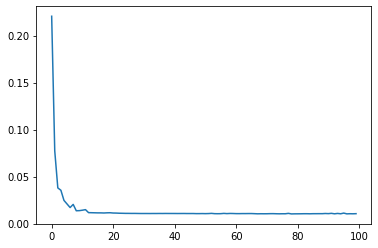

In [7]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'temporature/sample',
    'temporature/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    

result_dic={}
evalution_costplt=[]    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 16, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f7c78506b50>
Y_2 =  (None, 16, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7d44173250>, <gast.gast.Return object at 0x7f7d441732d0>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7d44173250>, <gast.gast.Return object at 0x7f7d441732d0>]
inputs :  Tensor("rnn_22/transpose_1:0", shape=(None, 16, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 16), dtype=float32)
enco

(13921, 16, 1) (13921, 10, 16, 1) (13921, 10, 16, 1) (13921, 16, 1) (13921, 1)
0.7811987511813641
0.31941994139924645
epoch : 22, t_cost : 0.012400, e_cost : 0.011830, elapsed time : 10.96sec
(32479, 16, 1) (32479, 10, 16, 1) (32479, 10, 16, 1) (32479, 16, 1) (32479, 1)
(13921, 16, 1) (13921, 10, 16, 1) (13921, 10, 16, 1) (13921, 16, 1) (13921, 1)
0.7672498661559075
0.32307305838912725
epoch : 23, t_cost : 0.012179, e_cost : 0.011966, elapsed time : 10.97sec
(32479, 16, 1) (32479, 10, 16, 1) (32479, 10, 16, 1) (32479, 16, 1) (32479, 1)
(13921, 16, 1) (13921, 10, 16, 1) (13921, 10, 16, 1) (13921, 16, 1) (13921, 1)
0.7662178452592343
0.31705970619805157
epoch : 24, t_cost : 0.012162, e_cost : 0.011743, elapsed time : 10.99sec
(32479, 16, 1) (32479, 10, 16, 1) (32479, 10, 16, 1) (32479, 16, 1) (32479, 1)
(13921, 16, 1) (13921, 10, 16, 1) (13921, 10, 16, 1) (13921, 16, 1) (13921, 1)
0.7625788270961493
0.32017147296573967
epoch : 25, t_cost : 0.012104, e_cost : 0.011858, elapsed time : 10.9

0.7139214775525033
0.3052314840024337
epoch : 52, t_cost : 0.011332, e_cost : 0.011305, elapsed time : 10.98sec
(32479, 16, 1) (32479, 10, 16, 1) (32479, 10, 16, 1) (32479, 16, 1) (32479, 1)
(13921, 16, 1) (13921, 10, 16, 1) (13921, 10, 16, 1) (13921, 16, 1) (13921, 1)
0.7101257438771427
0.3039927367353812
epoch : 53, t_cost : 0.011272, e_cost : 0.011259, elapsed time : 11.00sec
(32479, 16, 1) (32479, 10, 16, 1) (32479, 10, 16, 1) (32479, 16, 1) (32479, 1)
(13921, 16, 1) (13921, 10, 16, 1) (13921, 10, 16, 1) (13921, 16, 1) (13921, 1)
0.7130308416672051
0.3007829758571461
epoch : 54, t_cost : 0.011318, e_cost : 0.011140, elapsed time : 10.96sec
(32479, 16, 1) (32479, 10, 16, 1) (32479, 10, 16, 1) (32479, 16, 1) (32479, 1)
(13921, 16, 1) (13921, 10, 16, 1) (13921, 10, 16, 1) (13921, 16, 1) (13921, 1)
0.7052569764200598
0.29427411570213735
epoch : 55, t_cost : 0.011195, e_cost : 0.010899, elapsed time : 10.96sec
(32479, 16, 1) (32479, 10, 16, 1) (32479, 10, 16, 1) (32479, 16, 1) (32479, 1

(13921, 16, 1) (13921, 10, 16, 1) (13921, 10, 16, 1) (13921, 16, 1) (13921, 1)
0.6645689371507615
0.2961127650924027
epoch : 83, t_cost : 0.010549, e_cost : 0.010967, elapsed time : 10.97sec
(32479, 16, 1) (32479, 10, 16, 1) (32479, 10, 16, 1) (32479, 16, 1) (32479, 1)
(13921, 16, 1) (13921, 10, 16, 1) (13921, 10, 16, 1) (13921, 16, 1) (13921, 1)
0.6603398791048676
0.2872484694235027
epoch : 84, t_cost : 0.010482, e_cost : 0.010639, elapsed time : 11.00sec
(32479, 16, 1) (32479, 10, 16, 1) (32479, 10, 16, 1) (32479, 16, 1) (32479, 1)
(13921, 16, 1) (13921, 10, 16, 1) (13921, 10, 16, 1) (13921, 16, 1) (13921, 1)
0.6489910795353353
0.2842993412632495
epoch : 85, t_cost : 0.010301, e_cost : 0.010530, elapsed time : 10.97sec
(32479, 16, 1) (32479, 10, 16, 1) (32479, 10, 16, 1) (32479, 16, 1) (32479, 1)
(13921, 16, 1) (13921, 10, 16, 1) (13921, 10, 16, 1) (13921, 16, 1) (13921, 1)
0.6485017077066004
0.2887023922521621
epoch : 86, t_cost : 0.010294, e_cost : 0.010693, elapsed time : 10.96sec

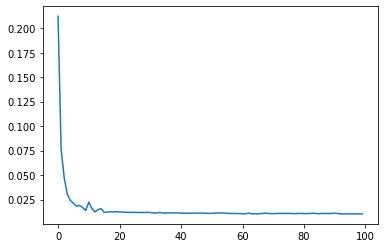

In [8]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=100
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'temporature/sample',
    'temporature/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    

result_dic={}
evalution_costplt=[]    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 16, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f7c2054cad0>
Y_2 =  (None, 16, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7c2013ff50>, <gast.gast.Return object at 0x7f7c2013ffd0>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7c2013ff50>, <gast.gast.Return object at 0x7f7c2013ffd0>]
inputs :  Tensor("rnn_22/transpose_1:0", shape=(None, 16, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 16), dtype=float32)
enco

(14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
0.7653665856923908
0.30672473390586674
epoch : 22, t_cost : 0.011959, e_cost : 0.011360, elapsed time : 11.16sec
(32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
0.7666500466875732
0.30872431630268693
epoch : 23, t_cost : 0.011979, e_cost : 0.011434, elapsed time : 11.13sec
(32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
0.7638432602398098
0.31227471795864403
epoch : 24, t_cost : 0.011935, e_cost : 0.011566, elapsed time : 11.13sec
(32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
0.7563761901110411
0.31019315076991916
epoch : 25, t_cost : 0.011818, e_cost : 0.011489, elapsed time : 11.1

0.6811419513542205
0.2816259458195418
epoch : 52, t_cost : 0.010643, e_cost : 0.010431, elapsed time : 11.14sec
(32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
0.6841913408134133
0.28780219063628465
epoch : 53, t_cost : 0.010690, e_cost : 0.010659, elapsed time : 11.13sec
(32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
0.6988950748927891
0.2720015269005671
epoch : 54, t_cost : 0.010920, e_cost : 0.010074, elapsed time : 11.13sec
(32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
0.675851791864261
0.27664411591831595
epoch : 55, t_cost : 0.010560, e_cost : 0.010246, elapsed time : 11.15sec
(32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1

(14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
0.6116535637993366
0.2807929061818868
epoch : 83, t_cost : 0.009557, e_cost : 0.010400, elapsed time : 11.13sec
(32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
0.6233850356657058
0.2753340748604387
epoch : 84, t_cost : 0.009740, e_cost : 0.010198, elapsed time : 11.15sec
(32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
0.6264584315940738
0.27508913236670196
epoch : 85, t_cost : 0.009788, e_cost : 0.010188, elapsed time : 11.15sec
(32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
0.6220160238444805
0.27824274578597397
epoch : 86, t_cost : 0.009719, e_cost : 0.010305, elapsed time : 11.13s

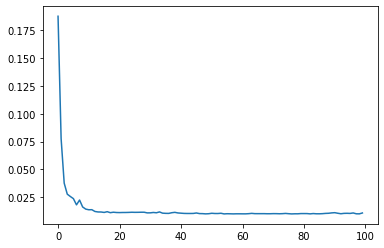

In [9]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=70
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'temporature/sample',
    'temporature/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    

result_dic={}
evalution_costplt=[]    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 32, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f7d3c6bba50>
Y_2 =  (None, 32, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7d045c1d90>, <gast.gast.Return object at 0x7f7d045c1e10>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7d045c1d90>, <gast.gast.Return object at 0x7f7d045c1e10>]
inputs :  Tensor("rnn_22/transpose_1:0", shape=(None, 32, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 32), dtype=float32)
enco

(14160, 32, 1) (14160, 10, 32, 1) (14160, 10, 32, 1) (14160, 32, 1) (14160, 1)
0.762566736259032
0.3050600769929588
epoch : 22, t_cost : 0.011915, e_cost : 0.011299, elapsed time : 22.67sec
(33040, 32, 1) (33040, 10, 32, 1) (33040, 10, 32, 1) (33040, 32, 1) (33040, 1)
(14160, 32, 1) (14160, 10, 32, 1) (14160, 10, 32, 1) (14160, 32, 1) (14160, 1)
0.7590318819275126
0.29771459312178195
epoch : 23, t_cost : 0.011860, e_cost : 0.011026, elapsed time : 22.64sec
(33040, 32, 1) (33040, 10, 32, 1) (33040, 10, 32, 1) (33040, 32, 1) (33040, 1)
(14160, 32, 1) (14160, 10, 32, 1) (14160, 10, 32, 1) (14160, 32, 1) (14160, 1)
0.7558148482930847
0.2952473177574575
epoch : 24, t_cost : 0.011810, e_cost : 0.010935, elapsed time : 22.69sec
(33040, 32, 1) (33040, 10, 32, 1) (33040, 10, 32, 1) (33040, 32, 1) (33040, 1)
(14160, 32, 1) (14160, 10, 32, 1) (14160, 10, 32, 1) (14160, 32, 1) (14160, 1)
0.7542827934958041
0.29387986613437533
epoch : 25, t_cost : 0.011786, e_cost : 0.010884, elapsed time : 22.60se

0.7138431023922749
0.288854792015627
epoch : 52, t_cost : 0.011154, e_cost : 0.010698, elapsed time : 22.60sec
(33040, 32, 1) (33040, 10, 32, 1) (33040, 10, 32, 1) (33040, 32, 1) (33040, 1)
(14160, 32, 1) (14160, 10, 32, 1) (14160, 10, 32, 1) (14160, 32, 1) (14160, 1)
0.7147733819438145
0.29637859784998
epoch : 53, t_cost : 0.011168, e_cost : 0.010977, elapsed time : 22.62sec
(33040, 32, 1) (33040, 10, 32, 1) (33040, 10, 32, 1) (33040, 32, 1) (33040, 1)
(14160, 32, 1) (14160, 10, 32, 1) (14160, 10, 32, 1) (14160, 32, 1) (14160, 1)
0.717333244276233
0.3208014499396086
epoch : 54, t_cost : 0.011208, e_cost : 0.011882, elapsed time : 22.66sec
(33040, 32, 1) (33040, 10, 32, 1) (33040, 10, 32, 1) (33040, 32, 1) (33040, 1)
(14160, 32, 1) (14160, 10, 32, 1) (14160, 10, 32, 1) (14160, 32, 1) (14160, 1)
0.7391447512200102
0.28825741936452687
epoch : 55, t_cost : 0.011549, e_cost : 0.010676, elapsed time : 22.62sec
(33040, 32, 1) (33040, 10, 32, 1) (33040, 10, 32, 1) (33040, 32, 1) (33040, 1)
(1

(14160, 32, 1) (14160, 10, 32, 1) (14160, 10, 32, 1) (14160, 32, 1) (14160, 1)
0.6824322633910924
0.288193566724658
epoch : 83, t_cost : 0.010663, e_cost : 0.010674, elapsed time : 22.59sec
(33040, 32, 1) (33040, 10, 32, 1) (33040, 10, 32, 1) (33040, 32, 1) (33040, 1)
(14160, 32, 1) (14160, 10, 32, 1) (14160, 10, 32, 1) (14160, 32, 1) (14160, 1)
0.6860207107383758
0.28701924497727305
epoch : 84, t_cost : 0.010719, e_cost : 0.010630, elapsed time : 22.57sec
(33040, 32, 1) (33040, 10, 32, 1) (33040, 10, 32, 1) (33040, 32, 1) (33040, 1)
(14160, 32, 1) (14160, 10, 32, 1) (14160, 10, 32, 1) (14160, 32, 1) (14160, 1)
0.6804296509362757
0.2820227111224085
epoch : 85, t_cost : 0.010632, e_cost : 0.010445, elapsed time : 22.74sec
(33040, 32, 1) (33040, 10, 32, 1) (33040, 10, 32, 1) (33040, 32, 1) (33040, 1)
(14160, 32, 1) (14160, 10, 32, 1) (14160, 10, 32, 1) (14160, 32, 1) (14160, 1)
0.6737045076442882
0.28481486183591187
epoch : 86, t_cost : 0.010527, e_cost : 0.010549, elapsed time : 22.69se

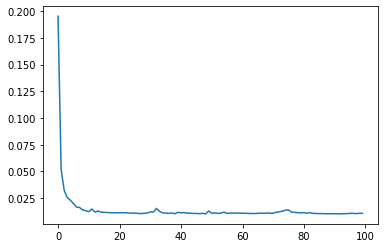

In [11]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'temporature/sample',
    'temporature/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    

result_dic={}
evalution_costplt=[]    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

In [12]:
class StockData():
    """
        훈련용 데이터세트와 평가용 데이터세트를 만들기 위한 과정.

        파라미터:
            folderPath : 종목시장의 주가 csv가 저장되어있는 디렉토리 경로.
            indexPath : 종목시장의 인덱스 주 csv파일의 경로.
            timewindowsize : LSTM의 입력으로 들어가는 타임의 사이즈. 10일 경우 미래주가를 예측하기 위해 이전 10일 주가를 사용.
            windowsizeForPCC : PCC를 계산하기 위해 사용되는 타임의 사이즈. 10일 경우 관계주를 구하기 위해 이전 10일 주가를 사용.
            PositiveStockNumber : 긍정관계주 개수.
            NegativeStockNumber : 부정관계주 개수.
            train_test_rate : 훈련:평가 세트 비율. 0.7일 경우 생성된 데이터 세트중 70%는 훈련용, 30%는 평가용으로 사용.
            batchSize : 세트를 나누는 배치 사이즈.

        과정:
            종목시장의 모든 종목의 시가와 인덱스 시가를 읽어옴.
            minmax스케일러를 각 종목과 인덱스에 적용하고 저장.
            PCC계산, 관계주 계산.
            데이터세트 저장.
               
    """
    def __init__(self,folderPath,indexPath,timewindowsize,windowsizeForPCC,PostiveStockNumber,NegativeStockNumber,train_test_rate,batchSize):        
               
        if(train_test_rate<=0 or train_test_rate>=1):
            raise ValueError('train_test_rate should be between 0 and 1')        
        self.P=PostiveStockNumber
        self.N=NegativeStockNumber        
        self.T=timewindowsize
        self.Tr=windowsizeForPCC
        self.folderPath = folderPath      
        self.indexPath=indexPath    
        self.batchSize=batchSize
        self.date_duration=3000
        
        self.train_test_rate=train_test_rate
        self.scaler=MinMaxScaler(feature_range=(-1,1))  
        self.indexScaler = MinMaxScaler(feature_range=(-1,1))

        self.indexPrice = self.loadIndex()
        self.stockPrice = self.loadCSV()

        self.trainSet,self.testSet=self.make_dataset()

        self.batchNum={}
    
    def getBatch(self,option):
        """
        클래스에 저장된 세트를 y,xp,xn,xi,target으로 나누고 batch생성.

        args:
            option='training' or 'evaluation'

        returns:
            batch 제너레이터
            batch={'y','xp','xn','xi','target'}
        """
        if(option is not 'training' and option is not 'evaluation'):
            raise ValueError('option should be "training" or "evaluation".')

        if(option is 'training'):
            returnSet = self.trainSet
        else:
            returnSet = self.testSet
        
        y=[]
        xp=[]
        xn=[]
        xi=[]
        target=[]

        for d in returnSet:
            y.append(d['target_history'])  
            xp.append(d['pos_history'])       
            xn.append(d['neg_history'])       
            xi.append(d['index_history'])       
            target.append(d['target_price'])             
        y=np.reshape(y,(-1,self.T,1))
        xp=np.reshape(xp,(-1,15,self.T,1))
        xn=np.reshape(xn,(-1,15,self.T,1))
        xi=np.reshape(xi,(-1,self.T,1))
        target=np.reshape(target,(-1,1))

        print(y.shape,xp.shape,xn.shape,xi.shape,target.shape)     

        batchNum=int(len(y)/self.batchSize)
        self.batchNum[option]=batchNum

        for i in range(batchNum):
            yield {'y':y[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xp':xp[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xn':xn[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xi':xi[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'target':target[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32)}

    def loadCSV(self):
        """
        csv파일이 있는 폴더를 입력으로 받아 데이터를 읽어옴.
        """
        csvList=os.listdir(self.folderPath)        
        dataframe = pd.DataFrame([])
        

        for csv in csvList:
            data=pd.read_csv(self.folderPath+'/'+csv,engine='python')
            if(len(data)>self.date_duration):
                data=data[-self.date_duration-1:-1]
                data=data.reset_index()
                data=data['open']

                dataframe=dataframe.append(data,ignore_index=True)
        dataT=np.array(dataframe).T
        self.scaler.fit(dataT)
        dataT=self.scaler.transform(dataT)
        dataT=dataT.T
        dataframe=pd.DataFrame(dataT)
        dataframe=dataframe.transpose()
        print('StockPrice shape: ',dataframe.shape)
        return dataframe
    
    def loadIndex(self):
        data=pd.read_csv(self.indexPath,engine='python')
        data=data[-self.date_duration-1:-1]        
        data=data.reset_index()
        data=data.fillna(method='ffill')

        data=np.array(data['Open'])
        data=np.reshape(data,(-1,1))

        data=self.indexScaler.fit_transform(data)

        data=pd.DataFrame(np.squeeze(data))        

        print('IndexPrice shape: ',data.shape)
        return data 


    def make_dataset(self):
        """
        예측모델에 사용되는 입력,타겟 데이터세트.
        입력데이터의 shape는 (목표주식+관계주식+인덱스, 타임윈도우사이즈)
        타겟데이터의 shape는 (1,1)
        """
        maxday=max([self.T,self.Tr])
        dataset=[]

        for i in range(maxday,len(self.stockPrice)):
            print('making dataset progress : {}/{}'.format(i,len(self.stockPrice)),end='\r')
            priceSet=self.stockPrice.loc[i-self.T:i-1]
            targetSet=self.stockPrice.loc[i]
            positiveSet,negativeSet=self.calculate_correlation(self.stockPrice.loc[i-maxday:i-1])
            indexSet = self.indexPrice.loc[i-self.T:i-1]

            for targetNum in priceSet.columns:
                target_history=np.reshape(np.array(priceSet[targetNum]),(self.T,1))
                pos_history=np.reshape(np.array(positiveSet[targetNum].T),(15,self.T,1))
                neg_history=np.reshape(np.array(negativeSet[targetNum].T),(15,self.T,1))
                index_history=np.reshape(np.array(indexSet),(self.T,1))
                target_price=np.reshape(np.array(targetSet[targetNum]),(1,1))

                dataset.append({'target_history':target_history,
                                'pos_history':pos_history,
                                'neg_history':neg_history,
                                'index_history':index_history,
                                'target_price':target_price
                            })
        print('making dataset progress : finished\t')
        
        return dataset[:int(len(dataset)*self.train_test_rate)],dataset[int(len(dataset)*self.train_test_rate):]

    def calculate_correlation(self,priceSet):
        """
        Pearson Correlation Coefficient(PCC)를 계산하고,
        높은순으로 긍정관계주, 낮은순으로 부정관계주를 설정한 개수만큼 생성하여 리스트에 저장한후, 리턴.
        입력은 전체 종목의 타임윈도우간의 주가.

        Returns:
            #모든종목의 관계주. 
            긍정관계주 shape = (종목 수, dataframe(T*P))
            부정관계주 shape = (종목 수, dataframe(T*N))
        """    
        positive=[]
        negative=[] 
        corr=priceSet[-self.Tr:].corr(method='pearson')

        for i in corr.columns:
            tempCorr=corr[i].sort_values(ascending=False)
            index_P=tempCorr[1:self.P+1].index
            index_N=tempCorr[-self.N:].index
            
            priceSet=priceSet[-self.T:]
            posSet=priceSet[index_P]
            negSet=priceSet[index_N]
            posSet.columns=range(self.P)
            negSet.columns=range(self.N)
            
            positive.append(posSet)
            negative.append(negSet)
        return positive,negative

            
"""testLine
kospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)
print(np.shape(kospi.trainSet))
print(np.shape(kospi.testSet))
"""


"testLine\nkospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)\nprint(np.shape(kospi.trainSet))\nprint(np.shape(kospi.testSet))\n"

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 32, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f7c403b2990>
Y_2 =  (None, 32, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7c401208d0>, <gast.gast.Return object at 0x7f7c40120950>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7c401208d0>, <gast.gast.Return object at 0x7f7c40120950>]
inputs :  Tensor("rnn_32/transpose_1:0", shape=(None, 32, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 32), dtype=float32)
enco

(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.7795125667471439
0.30395772820338607
epoch : 22, t_cost : 0.012180, e_cost : 0.011258, elapsed time : 28.87sec
(32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.7712817587889731
0.3005416775122285
epoch : 23, t_cost : 0.012051, e_cost : 0.011131, elapsed time : 28.90sec
(32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.7600388142745942
0.2980871053878218
epoch : 24, t_cost : 0.011876, e_cost : 0.011040, elapsed time : 28.92sec
(32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.7566703020129353
0.2922290835995227
epoch : 25, t_cost : 0.011823, e_cost : 0.010823, elapsed time : 28.91se

(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.6654523401521146
0.27624435536563396
epoch : 53, t_cost : 0.010398, e_cost : 0.010231, elapsed time : 28.90sec
(32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.6612074295990169
0.27404865249991417
epoch : 54, t_cost : 0.010331, e_cost : 0.010150, elapsed time : 28.86sec
(32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.6604830352589488
0.2784193295519799
epoch : 55, t_cost : 0.010320, e_cost : 0.010312, elapsed time : 28.91sec
(32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.7392506005708128
0.2947389595210552
epoch : 56, t_cost : 0.011551, e_cost : 0.010916, elapsed time : 28.93s

(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.6870473804883659
0.26770114235114306
epoch : 84, t_cost : 0.010735, e_cost : 0.009915, elapsed time : 28.93sec
(32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.666598895797506
0.280330324661918
epoch : 85, t_cost : 0.010416, e_cost : 0.010383, elapsed time : 28.90sec
(32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.6698156644124538
0.2761735380627215
epoch : 86, t_cost : 0.010466, e_cost : 0.010229, elapsed time : 28.89sec
(32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.6534668358508497
0.27521721192169935
epoch : 87, t_cost : 0.010210, e_cost : 0.010193, elapsed time : 28.93sec

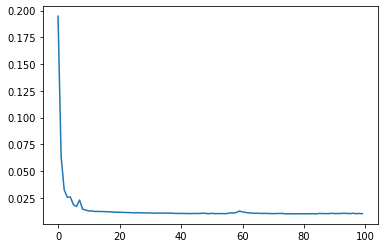

In [13]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'temporature/sample',
    'temporature/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    

result_dic={}
evalution_costplt=[]    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 16, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f7d2c550d10>
Y_2 =  (None, 16, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7d3c5e50d0>, <gast.gast.Return object at 0x7f7d3c5e5150>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7d3c5e50d0>, <gast.gast.Return object at 0x7f7d3c5e5150>]
inputs :  Tensor("rnn_32/transpose_1:0", shape=(None, 16, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 16), dtype=float32)
enco

(14160, 16, 1) (14160, 15, 16, 1) (14160, 15, 16, 1) (14160, 16, 1) (14160, 1)
0.7688412949210033
0.2973357974551618
epoch : 22, t_cost : 0.012013, e_cost : 0.011012, elapsed time : 14.69sec
(33040, 16, 1) (33040, 15, 16, 1) (33040, 15, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 15, 16, 1) (14160, 15, 16, 1) (14160, 16, 1) (14160, 1)
0.7519123636302538
0.29361608740873635
epoch : 23, t_cost : 0.011749, e_cost : 0.010875, elapsed time : 14.61sec
(33040, 16, 1) (33040, 15, 16, 1) (33040, 15, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 15, 16, 1) (14160, 15, 16, 1) (14160, 16, 1) (14160, 1)
0.7519550129654817
0.2930790721438825
epoch : 24, t_cost : 0.011749, e_cost : 0.010855, elapsed time : 14.34sec
(33040, 16, 1) (33040, 15, 16, 1) (33040, 15, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 15, 16, 1) (14160, 15, 16, 1) (14160, 16, 1) (14160, 1)
0.7403582113329321
0.2907556111458689
epoch : 25, t_cost : 0.011568, e_cost : 0.010769, elapsed time : 14.39se

(14160, 16, 1) (14160, 15, 16, 1) (14160, 15, 16, 1) (14160, 16, 1) (14160, 1)
0.6702633275999688
0.27060363604687154
epoch : 53, t_cost : 0.010473, e_cost : 0.010022, elapsed time : 14.26sec
(33040, 16, 1) (33040, 15, 16, 1) (33040, 15, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 15, 16, 1) (14160, 15, 16, 1) (14160, 16, 1) (14160, 1)
0.6792081068851985
0.2768999255495146
epoch : 54, t_cost : 0.010613, e_cost : 0.010256, elapsed time : 14.23sec
(33040, 16, 1) (33040, 15, 16, 1) (33040, 15, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 15, 16, 1) (14160, 15, 16, 1) (14160, 16, 1) (14160, 1)
0.6690216115675867
0.2694557448849082
epoch : 55, t_cost : 0.010453, e_cost : 0.009980, elapsed time : 14.23sec
(33040, 16, 1) (33040, 15, 16, 1) (33040, 15, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 15, 16, 1) (14160, 15, 16, 1) (14160, 16, 1) (14160, 1)
0.6794968876056373
0.2675043464405462
epoch : 56, t_cost : 0.010617, e_cost : 0.009908, elapsed time : 14.26se

(14160, 16, 1) (14160, 15, 16, 1) (14160, 15, 16, 1) (14160, 16, 1) (14160, 1)
0.6949987387051806
0.2915550796315074
epoch : 84, t_cost : 0.010859, e_cost : 0.010798, elapsed time : 14.36sec
(33040, 16, 1) (33040, 15, 16, 1) (33040, 15, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 15, 16, 1) (14160, 15, 16, 1) (14160, 16, 1) (14160, 1)
0.6918366830796003
0.2952422669623047
epoch : 85, t_cost : 0.010810, e_cost : 0.010935, elapsed time : 14.33sec
(33040, 16, 1) (33040, 15, 16, 1) (33040, 15, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 15, 16, 1) (14160, 15, 16, 1) (14160, 16, 1) (14160, 1)
0.6960093749221414
0.30352049181237817
epoch : 86, t_cost : 0.010875, e_cost : 0.011241, elapsed time : 14.67sec
(33040, 16, 1) (33040, 15, 16, 1) (33040, 15, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 15, 16, 1) (14160, 15, 16, 1) (14160, 16, 1) (14160, 1)
0.6994669206324033
0.30698751960881054
epoch : 87, t_cost : 0.010929, e_cost : 0.011370, elapsed time : 14.50s

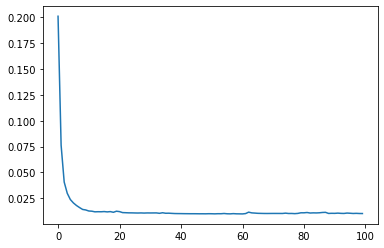

In [14]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'temporature/sample',
    'temporature/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    

result_dic={}
evalution_costplt=[]    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 16, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f7a247fb0d0>
Y_2 =  (None, 16, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7c403ea110>, <gast.gast.Return object at 0x7f7c403ea190>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7c403ea110>, <gast.gast.Return object at 0x7f7c403ea190>]
inputs :  Tensor("rnn_32/transpose_1:0", shape=(None, 16, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 16), dtype=float32)
enco

(14064, 16, 1) (14064, 15, 16, 1) (14064, 15, 16, 1) (14064, 16, 1) (14064, 1)
0.7648041290231049
0.3242119688075036
epoch : 22, t_cost : 0.011950, e_cost : 0.012008, elapsed time : 14.27sec
(32816, 16, 1) (32816, 15, 16, 1) (32816, 15, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 15, 16, 1) (14064, 15, 16, 1) (14064, 16, 1) (14064, 1)
0.7643562215380371
0.32407840341329575
epoch : 23, t_cost : 0.011943, e_cost : 0.012003, elapsed time : 14.25sec
(32816, 16, 1) (32816, 15, 16, 1) (32816, 15, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 15, 16, 1) (14064, 15, 16, 1) (14064, 16, 1) (14064, 1)
0.7601361572742462
0.3131292387843132
epoch : 24, t_cost : 0.011877, e_cost : 0.011597, elapsed time : 14.26sec
(32816, 16, 1) (32816, 15, 16, 1) (32816, 15, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 15, 16, 1) (14064, 15, 16, 1) (14064, 16, 1) (14064, 1)
0.7519325588364154
0.3101482689380646
epoch : 25, t_cost : 0.011749, e_cost : 0.011487, elapsed time : 14.29se

0.6960808951407671
0.2904986289795488
epoch : 52, t_cost : 0.010876, e_cost : 0.010759, elapsed time : 14.27sec
(32816, 16, 1) (32816, 15, 16, 1) (32816, 15, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 15, 16, 1) (14064, 15, 16, 1) (14064, 16, 1) (14064, 1)
0.7608416662551463
0.2908018818125129
epoch : 53, t_cost : 0.011888, e_cost : 0.010770, elapsed time : 14.28sec
(32816, 16, 1) (32816, 15, 16, 1) (32816, 15, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 15, 16, 1) (14064, 15, 16, 1) (14064, 16, 1) (14064, 1)
0.6988144158385694
0.2907784462440759
epoch : 54, t_cost : 0.010919, e_cost : 0.010770, elapsed time : 14.24sec
(32816, 16, 1) (32816, 15, 16, 1) (32816, 15, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 15, 16, 1) (14064, 15, 16, 1) (14064, 16, 1) (14064, 1)
0.7308858775068074
0.2884711545193568
epoch : 55, t_cost : 0.011420, e_cost : 0.010684, elapsed time : 14.26sec
(32816, 16, 1) (32816, 15, 16, 1) (32816, 15, 16, 1) (32816, 16, 1) (32816, 1)

(14064, 16, 1) (14064, 15, 16, 1) (14064, 15, 16, 1) (14064, 16, 1) (14064, 1)
0.6330980656202883
0.27712526614777744
epoch : 83, t_cost : 0.009892, e_cost : 0.010264, elapsed time : 14.25sec
(32816, 16, 1) (32816, 15, 16, 1) (32816, 15, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 15, 16, 1) (14064, 15, 16, 1) (14064, 16, 1) (14064, 1)
0.657897541532293
0.27492671157233417
epoch : 84, t_cost : 0.010280, e_cost : 0.010182, elapsed time : 14.28sec
(32816, 16, 1) (32816, 15, 16, 1) (32816, 15, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 15, 16, 1) (14064, 15, 16, 1) (14064, 16, 1) (14064, 1)
0.6441379368770868
0.28990511898882687
epoch : 85, t_cost : 0.010065, e_cost : 0.010737, elapsed time : 14.27sec
(32816, 16, 1) (32816, 15, 16, 1) (32816, 15, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 15, 16, 1) (14064, 15, 16, 1) (14064, 16, 1) (14064, 1)
0.6948336637578905
0.2843271982856095
epoch : 86, t_cost : 0.010857, e_cost : 0.010531, elapsed time : 14.24s

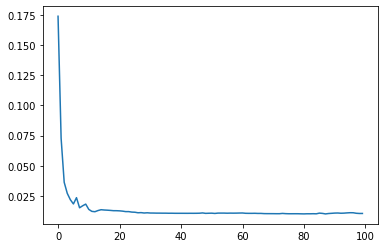

In [15]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'temporature/sample',
    'temporature/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    

result_dic={}
evalution_costplt=[]    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

In [16]:
class StockData():
    """
        훈련용 데이터세트와 평가용 데이터세트를 만들기 위한 과정.

        파라미터:
            folderPath : 종목시장의 주가 csv가 저장되어있는 디렉토리 경로.
            indexPath : 종목시장의 인덱스 주 csv파일의 경로.
            timewindowsize : LSTM의 입력으로 들어가는 타임의 사이즈. 10일 경우 미래주가를 예측하기 위해 이전 10일 주가를 사용.
            windowsizeForPCC : PCC를 계산하기 위해 사용되는 타임의 사이즈. 10일 경우 관계주를 구하기 위해 이전 10일 주가를 사용.
            PositiveStockNumber : 긍정관계주 개수.
            NegativeStockNumber : 부정관계주 개수.
            train_test_rate : 훈련:평가 세트 비율. 0.7일 경우 생성된 데이터 세트중 70%는 훈련용, 30%는 평가용으로 사용.
            batchSize : 세트를 나누는 배치 사이즈.

        과정:
            종목시장의 모든 종목의 시가와 인덱스 시가를 읽어옴.
            minmax스케일러를 각 종목과 인덱스에 적용하고 저장.
            PCC계산, 관계주 계산.
            데이터세트 저장.
               
    """
    def __init__(self,folderPath,indexPath,timewindowsize,windowsizeForPCC,PostiveStockNumber,NegativeStockNumber,train_test_rate,batchSize):        
               
        if(train_test_rate<=0 or train_test_rate>=1):
            raise ValueError('train_test_rate should be between 0 and 1')        
        self.P=PostiveStockNumber
        self.N=NegativeStockNumber        
        self.T=timewindowsize
        self.Tr=windowsizeForPCC
        self.folderPath = folderPath      
        self.indexPath=indexPath    
        self.batchSize=batchSize
        self.date_duration=3000
        
        self.train_test_rate=train_test_rate
        self.scaler=MinMaxScaler(feature_range=(-1,1))  
        self.indexScaler = MinMaxScaler(feature_range=(-1,1))

        self.indexPrice = self.loadIndex()
        self.stockPrice = self.loadCSV()

        self.trainSet,self.testSet=self.make_dataset()

        self.batchNum={}
    
    def getBatch(self,option):
        """
        클래스에 저장된 세트를 y,xp,xn,xi,target으로 나누고 batch생성.

        args:
            option='training' or 'evaluation'

        returns:
            batch 제너레이터
            batch={'y','xp','xn','xi','target'}
        """
        if(option is not 'training' and option is not 'evaluation'):
            raise ValueError('option should be "training" or "evaluation".')

        if(option is 'training'):
            returnSet = self.trainSet
        else:
            returnSet = self.testSet
        
        y=[]
        xp=[]
        xn=[]
        xi=[]
        target=[]

        for d in returnSet:
            y.append(d['target_history'])  
            xp.append(d['pos_history'])       
            xn.append(d['neg_history'])       
            xi.append(d['index_history'])       
            target.append(d['target_price'])             
        y=np.reshape(y,(-1,self.T,1))
        xp=np.reshape(xp,(-1,6,self.T,1))
        xn=np.reshape(xn,(-1,6,self.T,1))
        xi=np.reshape(xi,(-1,self.T,1))
        target=np.reshape(target,(-1,1))

        print(y.shape,xp.shape,xn.shape,xi.shape,target.shape)     

        batchNum=int(len(y)/self.batchSize)
        self.batchNum[option]=batchNum

        for i in range(batchNum):
            yield {'y':y[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xp':xp[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xn':xn[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xi':xi[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'target':target[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32)}

    def loadCSV(self):
        """
        csv파일이 있는 폴더를 입력으로 받아 데이터를 읽어옴.
        """
        csvList=os.listdir(self.folderPath)        
        dataframe = pd.DataFrame([])
        

        for csv in csvList:
            data=pd.read_csv(self.folderPath+'/'+csv,engine='python')
            if(len(data)>self.date_duration):
                data=data[-self.date_duration-1:-1]
                data=data.reset_index()
                data=data['open']

                dataframe=dataframe.append(data,ignore_index=True)
        dataT=np.array(dataframe).T
        self.scaler.fit(dataT)
        dataT=self.scaler.transform(dataT)
        dataT=dataT.T
        dataframe=pd.DataFrame(dataT)
        dataframe=dataframe.transpose()
        print('StockPrice shape: ',dataframe.shape)
        return dataframe
    
    def loadIndex(self):
        data=pd.read_csv(self.indexPath,engine='python')
        data=data[-self.date_duration-1:-1]        
        data=data.reset_index()
        data=data.fillna(method='ffill')

        data=np.array(data['Open'])
        data=np.reshape(data,(-1,1))

        data=self.indexScaler.fit_transform(data)

        data=pd.DataFrame(np.squeeze(data))        

        print('IndexPrice shape: ',data.shape)
        return data 


    def make_dataset(self):
        """
        예측모델에 사용되는 입력,타겟 데이터세트.
        입력데이터의 shape는 (목표주식+관계주식+인덱스, 타임윈도우사이즈)
        타겟데이터의 shape는 (1,1)
        """
        maxday=max([self.T,self.Tr])
        dataset=[]

        for i in range(maxday,len(self.stockPrice)):
            print('making dataset progress : {}/{}'.format(i,len(self.stockPrice)),end='\r')
            priceSet=self.stockPrice.loc[i-self.T:i-1]
            targetSet=self.stockPrice.loc[i]
            positiveSet,negativeSet=self.calculate_correlation(self.stockPrice.loc[i-maxday:i-1])
            indexSet = self.indexPrice.loc[i-self.T:i-1]

            for targetNum in priceSet.columns:
                target_history=np.reshape(np.array(priceSet[targetNum]),(self.T,1))
                pos_history=np.reshape(np.array(positiveSet[targetNum].T),(6,self.T,1))
                neg_history=np.reshape(np.array(negativeSet[targetNum].T),(6,self.T,1))
                index_history=np.reshape(np.array(indexSet),(self.T,1))
                target_price=np.reshape(np.array(targetSet[targetNum]),(1,1))

                dataset.append({'target_history':target_history,
                                'pos_history':pos_history,
                                'neg_history':neg_history,
                                'index_history':index_history,
                                'target_price':target_price
                            })
        print('making dataset progress : finished\t')
        
        return dataset[:int(len(dataset)*self.train_test_rate)],dataset[int(len(dataset)*self.train_test_rate):]

    def calculate_correlation(self,priceSet):
        """
        Pearson Correlation Coefficient(PCC)를 계산하고,
        높은순으로 긍정관계주, 낮은순으로 부정관계주를 설정한 개수만큼 생성하여 리스트에 저장한후, 리턴.
        입력은 전체 종목의 타임윈도우간의 주가.

        Returns:
            #모든종목의 관계주. 
            긍정관계주 shape = (종목 수, dataframe(T*P))
            부정관계주 shape = (종목 수, dataframe(T*N))
        """    
        positive=[]
        negative=[] 
        corr=priceSet[-self.Tr:].corr(method='pearson')

        for i in corr.columns:
            tempCorr=corr[i].sort_values(ascending=False)
            index_P=tempCorr[1:self.P+1].index
            index_N=tempCorr[-self.N:].index
            
            priceSet=priceSet[-self.T:]
            posSet=priceSet[index_P]
            negSet=priceSet[index_N]
            posSet.columns=range(self.P)
            negSet.columns=range(self.N)
            
            positive.append(posSet)
            negative.append(negSet)
        return positive,negative

            
"""testLine
kospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)
print(np.shape(kospi.trainSet))
print(np.shape(kospi.testSet))
"""


"testLine\nkospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)\nprint(np.shape(kospi.trainSet))\nprint(np.shape(kospi.testSet))\n"

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 16, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f7a3ca6c8d0>
Y_2 =  (None, 16, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7d3c33e8d0>, <gast.gast.Return object at 0x7f7d3c33e950>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7d3c33e8d0>, <gast.gast.Return object at 0x7f7d3c33e950>]
inputs :  Tensor("rnn_14/transpose_1:0", shape=(None, 16, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 16), dtype=float32)
enco

(14160, 16, 1) (14160, 6, 16, 1) (14160, 6, 16, 1) (14160, 16, 1) (14160, 1)
0.7679266834165901
0.29916189471259713
epoch : 22, t_cost : 0.011999, e_cost : 0.011080, elapsed time : 8.70sec
(33040, 16, 1) (33040, 6, 16, 1) (33040, 6, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 6, 16, 1) (14160, 6, 16, 1) (14160, 16, 1) (14160, 1)
0.7705411779461429
0.2958926889114082
epoch : 23, t_cost : 0.012040, e_cost : 0.010959, elapsed time : 8.68sec
(33040, 16, 1) (33040, 6, 16, 1) (33040, 6, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 6, 16, 1) (14160, 6, 16, 1) (14160, 16, 1) (14160, 1)
0.7642348778899759
0.2952327255625278
epoch : 24, t_cost : 0.011941, e_cost : 0.010935, elapsed time : 8.68sec
(33040, 16, 1) (33040, 6, 16, 1) (33040, 6, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 6, 16, 1) (14160, 6, 16, 1) (14160, 16, 1) (14160, 1)
0.7597304258379154
0.2936662684660405
epoch : 25, t_cost : 0.011871, e_cost : 0.010877, elapsed time : 8.68sec
(33040, 16, 1) (

(14160, 16, 1) (14160, 6, 16, 1) (14160, 6, 16, 1) (14160, 16, 1) (14160, 1)
0.7184840099071153
0.2819422469474375
epoch : 53, t_cost : 0.011226, e_cost : 0.010442, elapsed time : 9.18sec
(33040, 16, 1) (33040, 6, 16, 1) (33040, 6, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 6, 16, 1) (14160, 6, 16, 1) (14160, 16, 1) (14160, 1)
0.7157570952549577
0.28415730386041105
epoch : 54, t_cost : 0.011184, e_cost : 0.010524, elapsed time : 9.05sec
(33040, 16, 1) (33040, 6, 16, 1) (33040, 6, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 6, 16, 1) (14160, 6, 16, 1) (14160, 16, 1) (14160, 1)
0.7147216536686756
0.28052741242572665
epoch : 55, t_cost : 0.011168, e_cost : 0.010390, elapsed time : 9.09sec
(33040, 16, 1) (33040, 6, 16, 1) (33040, 6, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 6, 16, 1) (14160, 6, 16, 1) (14160, 16, 1) (14160, 1)
0.7068606742541306
0.28255181829445064
epoch : 56, t_cost : 0.011045, e_cost : 0.010465, elapsed time : 9.09sec
(33040, 16, 1)

(14160, 16, 1) (14160, 6, 16, 1) (14160, 6, 16, 1) (14160, 16, 1) (14160, 1)
0.635506707476452
0.2800829329062253
epoch : 84, t_cost : 0.009930, e_cost : 0.010373, elapsed time : 8.69sec
(33040, 16, 1) (33040, 6, 16, 1) (33040, 6, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 6, 16, 1) (14160, 6, 16, 1) (14160, 16, 1) (14160, 1)
0.6451865207054652
0.29479423188604414
epoch : 85, t_cost : 0.010081, e_cost : 0.010918, elapsed time : 8.69sec
(33040, 16, 1) (33040, 6, 16, 1) (33040, 6, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 6, 16, 1) (14160, 6, 16, 1) (14160, 16, 1) (14160, 1)
0.6261547161848284
0.28300540638156235
epoch : 86, t_cost : 0.009784, e_cost : 0.010482, elapsed time : 8.70sec
(33040, 16, 1) (33040, 6, 16, 1) (33040, 6, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 6, 16, 1) (14160, 6, 16, 1) (14160, 16, 1) (14160, 1)
0.6304148391936906
0.2912270426750183
epoch : 87, t_cost : 0.009850, e_cost : 0.010786, elapsed time : 8.68sec
(33040, 16, 1) (

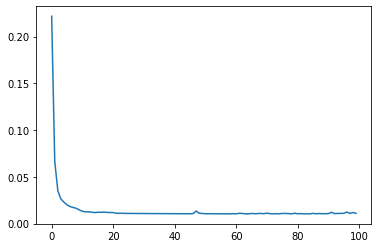

In [17]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=6
negative_correlation_sotck_num=6
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'temporature/sample',
    'temporature/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    

result_dic={}
evalution_costplt=[]    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 16, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f7a2d750750>
Y_2 =  (None, 16, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7a2d5a8990>, <gast.gast.Return object at 0x7f7a2d5a8a10>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7a2d5a8990>, <gast.gast.Return object at 0x7f7a2d5a8a10>]
inputs :  Tensor("rnn_14/transpose_1:0", shape=(None, 16, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 16), dtype=float32)
enco

(14064, 16, 1) (14064, 6, 16, 1) (14064, 6, 16, 1) (14064, 16, 1) (14064, 1)
0.7641845538746566
0.3219835623167455
epoch : 22, t_cost : 0.011940, e_cost : 0.011925, elapsed time : 8.70sec
(32816, 16, 1) (32816, 6, 16, 1) (32816, 6, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 6, 16, 1) (14064, 6, 16, 1) (14064, 16, 1) (14064, 1)
0.7572644033934921
0.3150098545011133
epoch : 23, t_cost : 0.011832, e_cost : 0.011667, elapsed time : 8.73sec
(32816, 16, 1) (32816, 6, 16, 1) (32816, 6, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 6, 16, 1) (14064, 6, 16, 1) (14064, 16, 1) (14064, 1)
0.760108575457707
0.315446158638224
epoch : 24, t_cost : 0.011877, e_cost : 0.011683, elapsed time : 8.71sec
(32816, 16, 1) (32816, 6, 16, 1) (32816, 6, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 6, 16, 1) (14064, 6, 16, 1) (14064, 16, 1) (14064, 1)
0.7548485114239156
0.3011045448947698
epoch : 25, t_cost : 0.011795, e_cost : 0.011152, elapsed time : 8.71sec
(32816, 16, 1) (328

(14064, 16, 1) (14064, 6, 16, 1) (14064, 6, 16, 1) (14064, 16, 1) (14064, 1)
0.6761806569993496
0.2735478481044993
epoch : 53, t_cost : 0.010565, e_cost : 0.010131, elapsed time : 8.71sec
(32816, 16, 1) (32816, 6, 16, 1) (32816, 6, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 6, 16, 1) (14064, 6, 16, 1) (14064, 16, 1) (14064, 1)
0.6604206999763846
0.2741477987729013
epoch : 54, t_cost : 0.010319, e_cost : 0.010154, elapsed time : 8.70sec
(32816, 16, 1) (32816, 6, 16, 1) (32816, 6, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 6, 16, 1) (14064, 6, 16, 1) (14064, 16, 1) (14064, 1)
0.6473552812822163
0.2740260986611247
epoch : 55, t_cost : 0.010115, e_cost : 0.010149, elapsed time : 8.72sec
(32816, 16, 1) (32816, 6, 16, 1) (32816, 6, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 6, 16, 1) (14064, 6, 16, 1) (14064, 16, 1) (14064, 1)
0.645914186257869
0.2725796140730381
epoch : 56, t_cost : 0.010092, e_cost : 0.010096, elapsed time : 8.71sec
(32816, 16, 1) (32

(14064, 16, 1) (14064, 6, 16, 1) (14064, 6, 16, 1) (14064, 16, 1) (14064, 1)
0.6328354142606258
0.285601741168648
epoch : 84, t_cost : 0.009888, e_cost : 0.010578, elapsed time : 8.75sec
(32816, 16, 1) (32816, 6, 16, 1) (32816, 6, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 6, 16, 1) (14064, 6, 16, 1) (14064, 16, 1) (14064, 1)
0.6084035804960877
0.28504899761173874
epoch : 85, t_cost : 0.009506, e_cost : 0.010557, elapsed time : 8.72sec
(32816, 16, 1) (32816, 6, 16, 1) (32816, 6, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 6, 16, 1) (14064, 6, 16, 1) (14064, 16, 1) (14064, 1)
0.6025693679694086
0.2843794790096581
epoch : 86, t_cost : 0.009415, e_cost : 0.010533, elapsed time : 8.71sec
(32816, 16, 1) (32816, 6, 16, 1) (32816, 6, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 6, 16, 1) (14064, 6, 16, 1) (14064, 16, 1) (14064, 1)
0.5984303912846372
0.29075265559367836
epoch : 87, t_cost : 0.009350, e_cost : 0.010769, elapsed time : 8.71sec
(32816, 16, 1) (

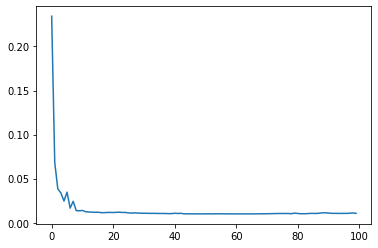

In [18]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=70
positive_correlation_stock_num=6
negative_correlation_sotck_num=6
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'temporature/sample',
    'temporature/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    

result_dic={}
evalution_costplt=[]    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 32, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f7c78415c90>
Y_2 =  (None, 32, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7d0436b990>, <gast.gast.Return object at 0x7f7d0436b950>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7d0436b990>, <gast.gast.Return object at 0x7f7d0436b950>]
inputs :  Tensor("rnn_14/transpose_1:0", shape=(None, 32, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 32), dtype=float32)
enco

(14064, 32, 1) (14064, 6, 32, 1) (14064, 6, 32, 1) (14064, 32, 1) (14064, 1)
0.7853235695511103
0.3150449402164668
epoch : 22, t_cost : 0.012271, e_cost : 0.011668, elapsed time : 17.63sec
(32816, 32, 1) (32816, 6, 32, 1) (32816, 6, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 6, 32, 1) (14064, 6, 32, 1) (14064, 32, 1) (14064, 1)
0.7808249578811228
0.31124225934036076
epoch : 23, t_cost : 0.012200, e_cost : 0.011527, elapsed time : 17.56sec
(32816, 32, 1) (32816, 6, 32, 1) (32816, 6, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 6, 32, 1) (14064, 6, 32, 1) (14064, 32, 1) (14064, 1)
0.7764575358014554
0.3103462310973555
epoch : 24, t_cost : 0.012132, e_cost : 0.011494, elapsed time : 17.61sec
(32816, 32, 1) (32816, 6, 32, 1) (32816, 6, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 6, 32, 1) (14064, 6, 32, 1) (14064, 32, 1) (14064, 1)
0.7748577932361513
0.3087755942251533
epoch : 25, t_cost : 0.012107, e_cost : 0.011436, elapsed time : 17.59sec
(32816, 32, 

(14064, 32, 1) (14064, 6, 32, 1) (14064, 6, 32, 1) (14064, 32, 1) (14064, 1)
0.6947292669210583
0.28464784391690046
epoch : 53, t_cost : 0.010855, e_cost : 0.010543, elapsed time : 17.61sec
(32816, 32, 1) (32816, 6, 32, 1) (32816, 6, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 6, 32, 1) (14064, 6, 32, 1) (14064, 32, 1) (14064, 1)
0.6905817047227174
0.28450207819696516
epoch : 54, t_cost : 0.010790, e_cost : 0.010537, elapsed time : 17.59sec
(32816, 32, 1) (32816, 6, 32, 1) (32816, 6, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 6, 32, 1) (14064, 6, 32, 1) (14064, 32, 1) (14064, 1)
0.6881727925501764
0.2835207673488185
epoch : 55, t_cost : 0.010753, e_cost : 0.010501, elapsed time : 17.60sec
(32816, 32, 1) (32816, 6, 32, 1) (32816, 6, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 6, 32, 1) (14064, 6, 32, 1) (14064, 32, 1) (14064, 1)
0.6844844091683626
0.2819410216761753
epoch : 56, t_cost : 0.010695, e_cost : 0.010442, elapsed time : 17.63sec
(32816, 32,

(14064, 32, 1) (14064, 6, 32, 1) (14064, 6, 32, 1) (14064, 32, 1) (14064, 1)
0.5737365501699969
0.303024317487143
epoch : 84, t_cost : 0.008965, e_cost : 0.011223, elapsed time : 17.60sec
(32816, 32, 1) (32816, 6, 32, 1) (32816, 6, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 6, 32, 1) (14064, 6, 32, 1) (14064, 32, 1) (14064, 1)
0.5692662987858057
0.28071276552509516
epoch : 85, t_cost : 0.008895, e_cost : 0.010397, elapsed time : 17.65sec
(32816, 32, 1) (32816, 6, 32, 1) (32816, 6, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 6, 32, 1) (14064, 6, 32, 1) (14064, 32, 1) (14064, 1)
0.573932645143941
0.28505170915741473
epoch : 86, t_cost : 0.008968, e_cost : 0.010557, elapsed time : 17.58sec
(32816, 32, 1) (32816, 6, 32, 1) (32816, 6, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 6, 32, 1) (14064, 6, 32, 1) (14064, 32, 1) (14064, 1)
0.5849716810043901
0.28437597188167274
epoch : 87, t_cost : 0.009140, e_cost : 0.010532, elapsed time : 17.61sec
(32816, 32, 

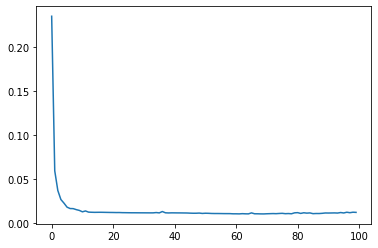

In [19]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=70
positive_correlation_stock_num=6
negative_correlation_sotck_num=6
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'temporature/sample',#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'temporature/sample',
    'temporature/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    

result_dic={}
evalution_costplt=[]    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))
    'temporature/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    

result_dic={}
evalution_costplt=[]    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

In [20]:
class StockData():
    """
        훈련용 데이터세트와 평가용 데이터세트를 만들기 위한 과정.

        파라미터:
            folderPath : 종목시장의 주가 csv가 저장되어있는 디렉토리 경로.
            indexPath : 종목시장의 인덱스 주 csv파일의 경로.
            timewindowsize : LSTM의 입력으로 들어가는 타임의 사이즈. 10일 경우 미래주가를 예측하기 위해 이전 10일 주가를 사용.
            windowsizeForPCC : PCC를 계산하기 위해 사용되는 타임의 사이즈. 10일 경우 관계주를 구하기 위해 이전 10일 주가를 사용.
            PositiveStockNumber : 긍정관계주 개수.
            NegativeStockNumber : 부정관계주 개수.
            train_test_rate : 훈련:평가 세트 비율. 0.7일 경우 생성된 데이터 세트중 70%는 훈련용, 30%는 평가용으로 사용.
            batchSize : 세트를 나누는 배치 사이즈.

        과정:
            종목시장의 모든 종목의 시가와 인덱스 시가를 읽어옴.
            minmax스케일러를 각 종목과 인덱스에 적용하고 저장.
            PCC계산, 관계주 계산.
            데이터세트 저장.
               
    """
    def __init__(self,folderPath,indexPath,timewindowsize,windowsizeForPCC,PostiveStockNumber,NegativeStockNumber,train_test_rate,batchSize):        
               
        if(train_test_rate<=0 or train_test_rate>=1):
            raise ValueError('train_test_rate should be between 0 and 1')        
        self.P=PostiveStockNumber
        self.N=NegativeStockNumber        
        self.T=timewindowsize
        self.Tr=windowsizeForPCC
        self.folderPath = folderPath      
        self.indexPath=indexPath    
        self.batchSize=batchSize
        self.date_duration=3000
        
        self.train_test_rate=train_test_rate
        self.scaler=MinMaxScaler(feature_range=(-1,1))  
        self.indexScaler = MinMaxScaler(feature_range=(-1,1))

        self.indexPrice = self.loadIndex()
        self.stockPrice = self.loadCSV()

        self.trainSet,self.testSet=self.make_dataset()

        self.batchNum={}
    
    def getBatch(self,option):
        """
        클래스에 저장된 세트를 y,xp,xn,xi,target으로 나누고 batch생성.

        args:
            option='training' or 'evaluation'

        returns:
            batch 제너레이터
            batch={'y','xp','xn','xi','target'}
        """
        if(option is not 'training' and option is not 'evaluation'):
            raise ValueError('option should be "training" or "evaluation".')

        if(option is 'training'):
            returnSet = self.trainSet
        else:
            returnSet = self.testSet
        
        y=[]
        xp=[]
        xn=[]
        xi=[]
        target=[]

        for d in returnSet:
            y.append(d['target_history'])  
            xp.append(d['pos_history'])       
            xn.append(d['neg_history'])       
            xi.append(d['index_history'])       
            target.append(d['target_price'])             
        y=np.reshape(y,(-1,self.T,1))
        xp=np.reshape(xp,(-1,4,self.T,1))
        xn=np.reshape(xn,(-1,4,self.T,1))
        xi=np.reshape(xi,(-1,self.T,1))
        target=np.reshape(target,(-1,1))

        print(y.shape,xp.shape,xn.shape,xi.shape,target.shape)     

        batchNum=int(len(y)/self.batchSize)
        self.batchNum[option]=batchNum

        for i in range(batchNum):
            yield {'y':y[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xp':xp[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xn':xn[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xi':xi[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'target':target[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32)}

    def loadCSV(self):
        """
        csv파일이 있는 폴더를 입력으로 받아 데이터를 읽어옴.
        """
        csvList=os.listdir(self.folderPath)        
        dataframe = pd.DataFrame([])
        

        for csv in csvList:
            data=pd.read_csv(self.folderPath+'/'+csv,engine='python')
            if(len(data)>self.date_duration):
                data=data[-self.date_duration-1:-1]
                data=data.reset_index()
                data=data['open']

                dataframe=dataframe.append(data,ignore_index=True)
        dataT=np.array(dataframe).T
        self.scaler.fit(dataT)
        dataT=self.scaler.transform(dataT)
        dataT=dataT.T
        dataframe=pd.DataFrame(dataT)
        dataframe=dataframe.transpose()
        print('StockPrice shape: ',dataframe.shape)
        return dataframe
    
    def loadIndex(self):
        data=pd.read_csv(self.indexPath,engine='python')
        data=data[-self.date_duration-1:-1]        
        data=data.reset_index()
        data=data.fillna(method='ffill')

        data=np.array(data['Open'])
        data=np.reshape(data,(-1,1))

        data=self.indexScaler.fit_transform(data)

        data=pd.DataFrame(np.squeeze(data))        

        print('IndexPrice shape: ',data.shape)
        return data 


    def make_dataset(self):
        """
        예측모델에 사용되는 입력,타겟 데이터세트.
        입력데이터의 shape는 (목표주식+관계주식+인덱스, 타임윈도우사이즈)
        타겟데이터의 shape는 (1,1)
        """
        maxday=max([self.T,self.Tr])
        dataset=[]

        for i in range(maxday,len(self.stockPrice)):
            print('making dataset progress : {}/{}'.format(i,len(self.stockPrice)),end='\r')
            priceSet=self.stockPrice.loc[i-self.T:i-1]
            targetSet=self.stockPrice.loc[i]
            positiveSet,negativeSet=self.calculate_correlation(self.stockPrice.loc[i-maxday:i-1])
            indexSet = self.indexPrice.loc[i-self.T:i-1]

            for targetNum in priceSet.columns:
                target_history=np.reshape(np.array(priceSet[targetNum]),(self.T,1))
                pos_history=np.reshape(np.array(positiveSet[targetNum].T),(4,self.T,1))
                neg_history=np.reshape(np.array(negativeSet[targetNum].T),(4,self.T,1))
                index_history=np.reshape(np.array(indexSet),(self.T,1))
                target_price=np.reshape(np.array(targetSet[targetNum]),(1,1))

                dataset.append({'target_history':target_history,
                                'pos_history':pos_history,
                                'neg_history':neg_history,
                                'index_history':index_history,
                                'target_price':target_price
                            })
        print('making dataset progress : finished\t')
        
        return dataset[:int(len(dataset)*self.train_test_rate)],dataset[int(len(dataset)*self.train_test_rate):]

    def calculate_correlation(self,priceSet):
        """
        Pearson Correlation Coefficient(PCC)를 계산하고,
        높은순으로 긍정관계주, 낮은순으로 부정관계주를 설정한 개수만큼 생성하여 리스트에 저장한후, 리턴.
        입력은 전체 종목의 타임윈도우간의 주가.

        Returns:
            #모든종목의 관계주. 
            긍정관계주 shape = (종목 수, dataframe(T*P))
            부정관계주 shape = (종목 수, dataframe(T*N))
        """    
        positive=[]
        negative=[] 
        corr=priceSet[-self.Tr:].corr(method='pearson')

        for i in corr.columns:
            tempCorr=corr[i].sort_values(ascending=False)
            index_P=tempCorr[1:self.P+1].index
            index_N=tempCorr[-self.N:].index
            
            priceSet=priceSet[-self.T:]
            posSet=priceSet[index_P]
            negSet=priceSet[index_N]
            posSet.columns=range(self.P)
            negSet.columns=range(self.N)
            
            positive.append(posSet)
            negative.append(negSet)
        return positive,negative

            
"""testLine
kospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)
print(np.shape(kospi.trainSet))
print(np.shape(kospi.testSet))
"""


"testLine\nkospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)\nprint(np.shape(kospi.trainSet))\nprint(np.shape(kospi.testSet))\n"

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 32, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f7d044724d0>
Y_2 =  (None, 32, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7d2c2a1410>, <gast.gast.Return object at 0x7f7d2c2a1490>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7d2c2a1410>, <gast.gast.Return object at 0x7f7d2c2a1490>]
inputs :  Tensor("rnn_10/transpose_1:0", shape=(None, 32, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 32), dtype=float32)
enco

(14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
0.7762426217086613
0.30410071765072644
epoch : 22, t_cost : 0.012129, e_cost : 0.011263, elapsed time : 15.08sec
(32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
0.7741963909938931
0.30315448716282845
epoch : 23, t_cost : 0.012097, e_cost : 0.011228, elapsed time : 15.11sec
(32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
0.8091265563853085
0.2981361476704478
epoch : 24, t_cost : 0.012643, e_cost : 0.011042, elapsed time : 15.09sec
(32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
0.8145279965829104
0.3123719182331115
epoch : 25, t_cost : 0.012727, e_cost : 0.011569, elapsed time : 15.10sec
(32816, 32,

(14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
0.7039899677038193
0.29611027461942285
epoch : 53, t_cost : 0.011000, e_cost : 0.010967, elapsed time : 15.11sec
(32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
0.6953369444236159
0.2895254479954019
epoch : 54, t_cost : 0.010865, e_cost : 0.010723, elapsed time : 15.09sec
(32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
0.6841462061274797
0.2917930049588904
epoch : 55, t_cost : 0.010690, e_cost : 0.010807, elapsed time : 15.04sec
(32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
0.6786679634824395
0.28989569458644837
epoch : 56, t_cost : 0.010604, e_cost : 0.010737, elapsed time : 15.06sec
(32816, 32,

(14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
0.7694718271959573
0.33676219289191067
epoch : 84, t_cost : 0.012023, e_cost : 0.012473, elapsed time : 15.02sec
(32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
0.765178352361545
0.3336765286512673
epoch : 85, t_cost : 0.011956, e_cost : 0.012358, elapsed time : 15.10sec
(32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
0.7651541524101049
0.33504991605877876
epoch : 86, t_cost : 0.011956, e_cost : 0.012409, elapsed time : 15.10sec
(32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
0.7619998077861965
0.33311823615804315
epoch : 87, t_cost : 0.011906, e_cost : 0.012338, elapsed time : 15.10sec
(32816, 32,

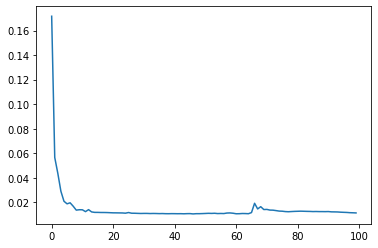

In [21]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=70
positive_correlation_stock_num=4
negative_correlation_sotck_num=4
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'temporature/sample',
    'temporature/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    

result_dic={}
evalution_costplt=[]    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 32, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f7d2c744390>
Y_2 =  (None, 32, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7a443dce10>, <gast.gast.Return object at 0x7f7a443dce90>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7a443dce10>, <gast.gast.Return object at 0x7f7a443dce90>]
inputs :  Tensor("rnn_10/transpose_1:0", shape=(None, 32, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 32), dtype=float32)
enco

(13921, 32, 1) (13921, 4, 32, 1) (13921, 4, 32, 1) (13921, 32, 1) (13921, 1)
0.7499324539676309
0.2968195191351697
epoch : 22, t_cost : 0.011904, e_cost : 0.010993, elapsed time : 14.90sec
(32479, 32, 1) (32479, 4, 32, 1) (32479, 4, 32, 1) (32479, 32, 1) (32479, 1)
(13921, 32, 1) (13921, 4, 32, 1) (13921, 4, 32, 1) (13921, 32, 1) (13921, 1)
0.7480392146389931
0.29538362356834114
epoch : 23, t_cost : 0.011874, e_cost : 0.010940, elapsed time : 14.89sec
(32479, 32, 1) (32479, 4, 32, 1) (32479, 4, 32, 1) (32479, 32, 1) (32479, 1)
(13921, 32, 1) (13921, 4, 32, 1) (13921, 4, 32, 1) (13921, 32, 1) (13921, 1)
0.7440978668164462
0.29415462631732225
epoch : 24, t_cost : 0.011811, e_cost : 0.010895, elapsed time : 14.90sec
(32479, 32, 1) (32479, 4, 32, 1) (32479, 4, 32, 1) (32479, 32, 1) (32479, 1)
(13921, 32, 1) (13921, 4, 32, 1) (13921, 4, 32, 1) (13921, 32, 1) (13921, 1)
0.7430380750447512
0.29255863174330443
epoch : 25, t_cost : 0.011794, e_cost : 0.010836, elapsed time : 14.90sec
(32479, 32

(13921, 32, 1) (13921, 4, 32, 1) (13921, 4, 32, 1) (13921, 32, 1) (13921, 1)
0.6916141326073557
0.3005963752511889
epoch : 53, t_cost : 0.010978, e_cost : 0.011133, elapsed time : 15.86sec
(32479, 32, 1) (32479, 4, 32, 1) (32479, 4, 32, 1) (32479, 32, 1) (32479, 1)
(13921, 32, 1) (13921, 4, 32, 1) (13921, 4, 32, 1) (13921, 32, 1) (13921, 1)
0.6926963008008897
0.3038258599117398
epoch : 54, t_cost : 0.010995, e_cost : 0.011253, elapsed time : 18.18sec
(32479, 32, 1) (32479, 4, 32, 1) (32479, 4, 32, 1) (32479, 32, 1) (32479, 1)
(13921, 32, 1) (13921, 4, 32, 1) (13921, 4, 32, 1) (13921, 32, 1) (13921, 1)
0.6869170262943953
0.3004769877297804
epoch : 55, t_cost : 0.010903, e_cost : 0.011129, elapsed time : 14.91sec
(32479, 32, 1) (32479, 4, 32, 1) (32479, 4, 32, 1) (32479, 32, 1) (32479, 1)
(13921, 32, 1) (13921, 4, 32, 1) (13921, 4, 32, 1) (13921, 32, 1) (13921, 1)
0.6883415575139225
0.30424276809208095
epoch : 56, t_cost : 0.010926, e_cost : 0.011268, elapsed time : 14.89sec
(32479, 32, 

(13921, 32, 1) (13921, 4, 32, 1) (13921, 4, 32, 1) (13921, 32, 1) (13921, 1)
0.6359327535610646
0.3281315783970058
epoch : 84, t_cost : 0.010094, e_cost : 0.012153, elapsed time : 14.90sec
(32479, 32, 1) (32479, 4, 32, 1) (32479, 4, 32, 1) (32479, 32, 1) (32479, 1)
(13921, 32, 1) (13921, 4, 32, 1) (13921, 4, 32, 1) (13921, 32, 1) (13921, 1)
0.6109805624000728
0.32423261262010783
epoch : 85, t_cost : 0.009698, e_cost : 0.012009, elapsed time : 14.92sec
(32479, 32, 1) (32479, 4, 32, 1) (32479, 4, 32, 1) (32479, 32, 1) (32479, 1)
(13921, 32, 1) (13921, 4, 32, 1) (13921, 4, 32, 1) (13921, 32, 1) (13921, 1)
0.6586347837001085
0.2910371220204979
epoch : 86, t_cost : 0.010455, e_cost : 0.010779, elapsed time : 14.88sec
(32479, 32, 1) (32479, 4, 32, 1) (32479, 4, 32, 1) (32479, 32, 1) (32479, 1)
(13921, 32, 1) (13921, 4, 32, 1) (13921, 4, 32, 1) (13921, 32, 1) (13921, 1)
0.6157212606631219
0.29630987520795316
epoch : 87, t_cost : 0.009773, e_cost : 0.010974, elapsed time : 14.91sec
(32479, 32,

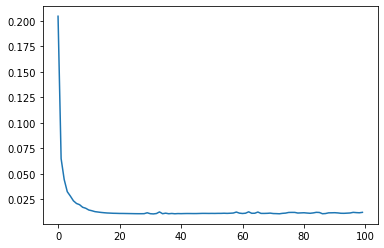

In [22]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=100
positive_correlation_stock_num=4
negative_correlation_sotck_num=4
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'temporature/sample',
    'temporature/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    

result_dic={}
evalution_costplt=[]    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 16, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f7a2d668290>
Y_2 =  (None, 16, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7a2d223510>, <gast.gast.Return object at 0x7f7a2d2231d0>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7a2d223510>, <gast.gast.Return object at 0x7f7a2d2231d0>]
inputs :  Tensor("rnn_10/transpose_1:0", shape=(None, 16, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 16), dtype=float32)
enco

(14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
0.7596447197720408
0.29603255563415587
epoch : 22, t_cost : 0.011869, e_cost : 0.010964, elapsed time : 7.50sec
(32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
0.7555645620450377
0.2980437900405377
epoch : 23, t_cost : 0.011806, e_cost : 0.011039, elapsed time : 7.49sec
(32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
0.7485786282923073
0.2958846956025809
epoch : 24, t_cost : 0.011697, e_cost : 0.010959, elapsed time : 7.49sec
(32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
0.7511060193646699
0.29461749317124486
epoch : 25, t_cost : 0.011736, e_cost : 0.010912, elapsed time : 7.51sec
(32816, 16, 1) 

(14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
0.6798611278645694
0.27639348653610796
epoch : 53, t_cost : 0.010623, e_cost : 0.010237, elapsed time : 7.50sec
(32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
0.7083107733633369
0.27902921091299504
epoch : 54, t_cost : 0.011067, e_cost : 0.010334, elapsed time : 7.51sec
(32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
0.6800013098400086
0.27820001530926675
epoch : 55, t_cost : 0.010625, e_cost : 0.010304, elapsed time : 7.51sec
(32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
0.7153486420866102
0.2811994784278795
epoch : 56, t_cost : 0.011177, e_cost : 0.010415, elapsed time : 7.49sec
(32816, 16, 1)

(14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
0.6112949646776542
0.27784566616173834
epoch : 84, t_cost : 0.009551, e_cost : 0.010291, elapsed time : 7.50sec
(32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
0.6089843581430614
0.27254068246111274
epoch : 85, t_cost : 0.009515, e_cost : 0.010094, elapsed time : 7.49sec
(32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
0.6361887061502784
0.2770408783107996
epoch : 86, t_cost : 0.009940, e_cost : 0.010261, elapsed time : 7.49sec
(32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
0.6075398430693895
0.284618757548742
epoch : 87, t_cost : 0.009493, e_cost : 0.010541, elapsed time : 7.50sec
(32816, 16, 1) (

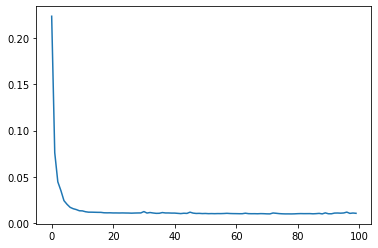

In [23]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=70
positive_correlation_stock_num=4
negative_correlation_sotck_num=4
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'temporature/sample',
    'temporature/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    

result_dic={}
evalution_costplt=[]    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 16, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f7da54f0e50>
Y_2 =  (None, 16, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7d2c46b810>, <gast.gast.Return object at 0x7f7d2c46be50>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7d2c46b810>, <gast.gast.Return object at 0x7f7d2c46be50>]
inputs :  Tensor("rnn_10/transpose_1:0", shape=(None, 16, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 16), dtype=float32)
enco

(13921, 16, 1) (13921, 4, 16, 1) (13921, 4, 16, 1) (13921, 16, 1) (13921, 1)
0.7676452067680657
0.29435948887839913
epoch : 22, t_cost : 0.012185, e_cost : 0.010902, elapsed time : 7.42sec
(32479, 16, 1) (32479, 4, 16, 1) (32479, 4, 16, 1) (32479, 16, 1) (32479, 1)
(13921, 16, 1) (13921, 4, 16, 1) (13921, 4, 16, 1) (13921, 16, 1) (13921, 1)
0.7459367846604437
0.2933490036521107
epoch : 23, t_cost : 0.011840, e_cost : 0.010865, elapsed time : 7.41sec
(32479, 16, 1) (32479, 4, 16, 1) (32479, 4, 16, 1) (32479, 16, 1) (32479, 1)
(13921, 16, 1) (13921, 4, 16, 1) (13921, 4, 16, 1) (13921, 16, 1) (13921, 1)
0.7424632222391665
0.29074830189347267
epoch : 24, t_cost : 0.011785, e_cost : 0.010768, elapsed time : 7.42sec
(32479, 16, 1) (32479, 4, 16, 1) (32479, 4, 16, 1) (32479, 16, 1) (32479, 1)
(13921, 16, 1) (13921, 4, 16, 1) (13921, 4, 16, 1) (13921, 16, 1) (13921, 1)
0.7386852600611746
0.2907004797598347
epoch : 25, t_cost : 0.011725, e_cost : 0.010767, elapsed time : 7.43sec
(32479, 16, 1) 

(13921, 16, 1) (13921, 4, 16, 1) (13921, 4, 16, 1) (13921, 16, 1) (13921, 1)
0.6661698163952678
0.2773890485987067
epoch : 53, t_cost : 0.010574, e_cost : 0.010274, elapsed time : 7.42sec
(32479, 16, 1) (32479, 4, 16, 1) (32479, 4, 16, 1) (32479, 16, 1) (32479, 1)
(13921, 16, 1) (13921, 4, 16, 1) (13921, 4, 16, 1) (13921, 16, 1) (13921, 1)
0.6709723654203117
0.27780503733083606
epoch : 54, t_cost : 0.010650, e_cost : 0.010289, elapsed time : 7.42sec
(32479, 16, 1) (32479, 4, 16, 1) (32479, 4, 16, 1) (32479, 16, 1) (32479, 1)
(13921, 16, 1) (13921, 4, 16, 1) (13921, 4, 16, 1) (13921, 16, 1) (13921, 1)
0.667645355919376
0.27911128604318947
epoch : 55, t_cost : 0.010598, e_cost : 0.010337, elapsed time : 7.41sec
(32479, 16, 1) (32479, 4, 16, 1) (32479, 4, 16, 1) (32479, 16, 1) (32479, 1)
(13921, 16, 1) (13921, 4, 16, 1) (13921, 4, 16, 1) (13921, 16, 1) (13921, 1)
0.6719937964808196
0.28164256492163986
epoch : 56, t_cost : 0.010667, e_cost : 0.010431, elapsed time : 7.43sec
(32479, 16, 1) 

(13921, 16, 1) (13921, 4, 16, 1) (13921, 4, 16, 1) (13921, 16, 1) (13921, 1)
0.6366566324140877
0.2767428014194593
epoch : 84, t_cost : 0.010106, e_cost : 0.010250, elapsed time : 7.42sec
(32479, 16, 1) (32479, 4, 16, 1) (32479, 4, 16, 1) (32479, 16, 1) (32479, 1)
(13921, 16, 1) (13921, 4, 16, 1) (13921, 4, 16, 1) (13921, 16, 1) (13921, 1)
0.6340545080602169
0.27791134221479297
epoch : 85, t_cost : 0.010064, e_cost : 0.010293, elapsed time : 7.41sec
(32479, 16, 1) (32479, 4, 16, 1) (32479, 4, 16, 1) (32479, 16, 1) (32479, 1)
(13921, 16, 1) (13921, 4, 16, 1) (13921, 4, 16, 1) (13921, 16, 1) (13921, 1)
0.6378153443802148
0.28108372748829424
epoch : 86, t_cost : 0.010124, e_cost : 0.010411, elapsed time : 7.41sec
(32479, 16, 1) (32479, 4, 16, 1) (32479, 4, 16, 1) (32479, 16, 1) (32479, 1)
(13921, 16, 1) (13921, 4, 16, 1) (13921, 4, 16, 1) (13921, 16, 1) (13921, 1)
0.6500225095078349
0.2789626666344702
epoch : 87, t_cost : 0.010318, e_cost : 0.010332, elapsed time : 7.42sec
(32479, 16, 1) 

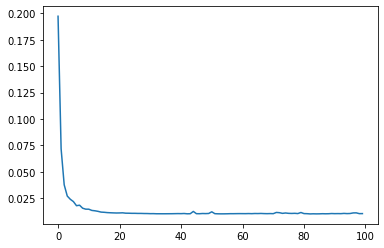

In [24]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=100
positive_correlation_stock_num=4
negative_correlation_sotck_num=4
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'temporature/sample',
    'temporature/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    

result_dic={}
evalution_costplt=[]    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 16, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f7a447243d0>
Y_2 =  (None, 16, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7a2cc4d6d0>, <gast.gast.Return object at 0x7f7a2cc4d750>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7a2cc4d6d0>, <gast.gast.Return object at 0x7f7a2cc4d750>]
inputs :  Tensor("rnn_10/transpose_1:0", shape=(None, 16, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 16), dtype=float32)
enco

(14160, 16, 1) (14160, 4, 16, 1) (14160, 4, 16, 1) (14160, 16, 1) (14160, 1)
1.543823705171235
0.809849239885807
epoch : 22, t_cost : 0.011968, e_cost : 0.014725, elapsed time : 14.93sec
(33040, 16, 1) (33040, 4, 16, 1) (33040, 4, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 4, 16, 1) (14160, 4, 16, 1) (14160, 16, 1) (14160, 1)
1.7143962084082887
0.6436237504240125
epoch : 23, t_cost : 0.013290, e_cost : 0.011702, elapsed time : 15.00sec
(33040, 16, 1) (33040, 4, 16, 1) (33040, 4, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 4, 16, 1) (14160, 4, 16, 1) (14160, 16, 1) (14160, 1)
1.5417403784231283
0.6701070601120591
epoch : 24, t_cost : 0.011951, e_cost : 0.012184, elapsed time : 14.93sec
(33040, 16, 1) (33040, 4, 16, 1) (33040, 4, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 4, 16, 1) (14160, 4, 16, 1) (14160, 16, 1) (14160, 1)
1.5334469878580421
0.68068280024454
epoch : 25, t_cost : 0.011887, e_cost : 0.012376, elapsed time : 14.94sec
(33040, 16, 1) (3

(14160, 16, 1) (14160, 4, 16, 1) (14160, 4, 16, 1) (14160, 16, 1) (14160, 1)
1.3264995960053056
0.5648395540192723
epoch : 53, t_cost : 0.010283, e_cost : 0.010270, elapsed time : 14.91sec
(33040, 16, 1) (33040, 4, 16, 1) (33040, 4, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 4, 16, 1) (14160, 4, 16, 1) (14160, 16, 1) (14160, 1)
1.3483745107077993
0.6530654951930046
epoch : 54, t_cost : 0.010453, e_cost : 0.011874, elapsed time : 14.91sec
(33040, 16, 1) (33040, 4, 16, 1) (33040, 4, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 4, 16, 1) (14160, 4, 16, 1) (14160, 16, 1) (14160, 1)
1.4369567515095696
0.5707159943412989
epoch : 55, t_cost : 0.011139, e_cost : 0.010377, elapsed time : 14.92sec
(33040, 16, 1) (33040, 4, 16, 1) (33040, 4, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 4, 16, 1) (14160, 4, 16, 1) (14160, 16, 1) (14160, 1)
1.343472003703937
0.5683670154539868
epoch : 56, t_cost : 0.010415, e_cost : 0.010334, elapsed time : 14.93sec
(33040, 16, 1)

(14160, 16, 1) (14160, 4, 16, 1) (14160, 4, 16, 1) (14160, 16, 1) (14160, 1)
1.0802636981243268
0.5808750543510541
epoch : 84, t_cost : 0.008374, e_cost : 0.010561, elapsed time : 14.90sec
(33040, 16, 1) (33040, 4, 16, 1) (33040, 4, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 4, 16, 1) (14160, 4, 16, 1) (14160, 16, 1) (14160, 1)
1.078380354505498
0.5957601522095501
epoch : 85, t_cost : 0.008360, e_cost : 0.010832, elapsed time : 14.90sec
(33040, 16, 1) (33040, 4, 16, 1) (33040, 4, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 4, 16, 1) (14160, 4, 16, 1) (14160, 16, 1) (14160, 1)
1.0685052687767893
0.5784560857573524
epoch : 86, t_cost : 0.008283, e_cost : 0.010517, elapsed time : 14.93sec
(33040, 16, 1) (33040, 4, 16, 1) (33040, 4, 16, 1) (33040, 16, 1) (33040, 1)
(14160, 16, 1) (14160, 4, 16, 1) (14160, 4, 16, 1) (14160, 16, 1) (14160, 1)
1.0311925378628075
0.5708230984164402
epoch : 87, t_cost : 0.007994, e_cost : 0.010379, elapsed time : 14.92sec
(33040, 16, 1)

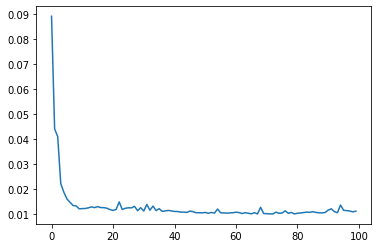

In [25]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=4
negative_correlation_sotck_num=4
train_test_rate=0.7
batch_size=256


kospi=StockData(
    'temporature/sample',
    'temporature/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    

result_dic={}
evalution_costplt=[]    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 16, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f7a155d8590>
Y_2 =  (None, 16, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7d3c14d250>, <gast.gast.Return object at 0x7f7d3c14d2d0>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7d3c14d250>, <gast.gast.Return object at 0x7f7d3c14d2d0>]
inputs :  Tensor("rnn_10/transpose_1:0", shape=(None, 16, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 16), dtype=float32)
enco

(14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
1.5237012800062075
0.6127382682170719
epoch : 22, t_cost : 0.011904, e_cost : 0.011347, elapsed time : 14.71sec
(32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
1.4960876882832963
0.6373270740732551
epoch : 23, t_cost : 0.011688, e_cost : 0.011802, elapsed time : 14.73sec
(32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
1.4893934406863991
0.6160131853539497
epoch : 24, t_cost : 0.011636, e_cost : 0.011408, elapsed time : 14.76sec
(32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
1.4815682769694831
0.6084266866091639
epoch : 25, t_cost : 0.011575, e_cost : 0.011267, elapsed time : 14.71sec
(32816, 16, 1

(14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
1.3169698329875246
0.5822180453687906
epoch : 53, t_cost : 0.010289, e_cost : 0.010782, elapsed time : 14.73sec
(32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
1.4000010029412806
0.5739591118181124
epoch : 54, t_cost : 0.010938, e_cost : 0.010629, elapsed time : 14.73sec
(32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
1.320446448342409
0.5789156826213002
epoch : 55, t_cost : 0.010316, e_cost : 0.010721, elapsed time : 14.71sec
(32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
1.3033437269041315
0.5608897455385886
epoch : 56, t_cost : 0.010182, e_cost : 0.010387, elapsed time : 14.72sec
(32816, 16, 1)

(14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
1.0047583416453563
0.6178924407577142
epoch : 84, t_cost : 0.007850, e_cost : 0.011442, elapsed time : 14.73sec
(32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
1.0585679072246421
0.6366284773685038
epoch : 85, t_cost : 0.008270, e_cost : 0.011789, elapsed time : 14.73sec
(32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
1.0255558949429542
0.5962674822076224
epoch : 86, t_cost : 0.008012, e_cost : 0.011042, elapsed time : 14.74sec
(32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
1.044646504247794
0.6236634233500808
epoch : 87, t_cost : 0.008161, e_cost : 0.011549, elapsed time : 14.73sec
(32816, 16, 1)

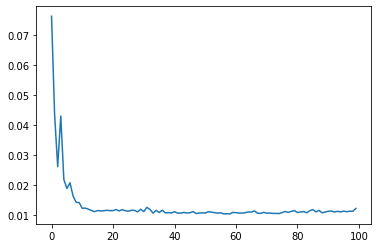

In [26]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=70
positive_correlation_stock_num=4
negative_correlation_sotck_num=4
train_test_rate=0.7
batch_size=256


kospi=StockData(
    'temporature/sample',
    'temporature/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    

result_dic={}
evalution_costplt=[]    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 32, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f7c98713e50>
Y_2 =  (None, 32, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7a2477add0>, <gast.gast.Return object at 0x7f7a2477a850>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7a2477add0>, <gast.gast.Return object at 0x7f7a2477a850>]
inputs :  Tensor("rnn_10/transpose_1:0", shape=(None, 32, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 32), dtype=float32)
enco

(14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
1.459427772424533
0.5672936474438757
epoch : 22, t_cost : 0.011402, e_cost : 0.010505, elapsed time : 29.79sec
(32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
1.4710326519561931
0.5633044430287555
epoch : 23, t_cost : 0.011492, e_cost : 0.010432, elapsed time : 29.81sec
(32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
1.4557333611592185
0.5784047953784466
epoch : 24, t_cost : 0.011373, e_cost : 0.010711, elapsed time : 29.81sec
(32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
1.4870949597097933
0.5713095775572583
epoch : 25, t_cost : 0.011618, e_cost : 0.010580, elapsed time : 29.81sec
(32816, 32, 1)

(14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
2.2074577630264685
0.6395669677294791
epoch : 53, t_cost : 0.017246, e_cost : 0.011844, elapsed time : 29.78sec
(32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
1.5538226478383876
0.6086114565841854
epoch : 54, t_cost : 0.012139, e_cost : 0.011271, elapsed time : 29.78sec
(32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
1.4620170286507346
0.599149689078331
epoch : 55, t_cost : 0.011422, e_cost : 0.011095, elapsed time : 29.83sec
(32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
1.4206099679868203
0.5930465629789978
epoch : 56, t_cost : 0.011099, e_cost : 0.010982, elapsed time : 29.78sec
(32816, 32, 1)

(14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
3.2757257860794198
1.2554115371312946
epoch : 84, t_cost : 0.025592, e_cost : 0.023248, elapsed time : 29.80sec
(32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
2.384791419375688
0.7350110654952005
epoch : 85, t_cost : 0.018631, e_cost : 0.013611, elapsed time : 29.81sec
(32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
1.847821562550962
0.6512932773912326
epoch : 86, t_cost : 0.014436, e_cost : 0.012061, elapsed time : 29.77sec
(32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
1.6051342778955586
0.6258625299669802
epoch : 87, t_cost : 0.012540, e_cost : 0.011590, elapsed time : 29.82sec
(32816, 32, 1) 

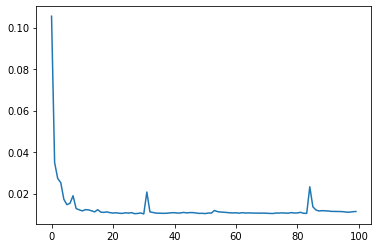

In [27]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=70
positive_correlation_stock_num=4
negative_correlation_sotck_num=4
train_test_rate=0.7
batch_size=256


kospi=StockData(
    'temporature/sample',
    'temporature/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    

result_dic={}
evalution_costplt=[]    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

In [28]:
class StockData():
    """
        훈련용 데이터세트와 평가용 데이터세트를 만들기 위한 과정.

        파라미터:
            folderPath : 종목시장의 주가 csv가 저장되어있는 디렉토리 경로.
            indexPath : 종목시장의 인덱스 주 csv파일의 경로.
            timewindowsize : LSTM의 입력으로 들어가는 타임의 사이즈. 10일 경우 미래주가를 예측하기 위해 이전 10일 주가를 사용.
            windowsizeForPCC : PCC를 계산하기 위해 사용되는 타임의 사이즈. 10일 경우 관계주를 구하기 위해 이전 10일 주가를 사용.
            PositiveStockNumber : 긍정관계주 개수.
            NegativeStockNumber : 부정관계주 개수.
            train_test_rate : 훈련:평가 세트 비율. 0.7일 경우 생성된 데이터 세트중 70%는 훈련용, 30%는 평가용으로 사용.
            batchSize : 세트를 나누는 배치 사이즈.

        과정:
            종목시장의 모든 종목의 시가와 인덱스 시가를 읽어옴.
            minmax스케일러를 각 종목과 인덱스에 적용하고 저장.
            PCC계산, 관계주 계산.
            데이터세트 저장.
               
    """
    def __init__(self,folderPath,indexPath,timewindowsize,windowsizeForPCC,PostiveStockNumber,NegativeStockNumber,train_test_rate,batchSize):        
               
        if(train_test_rate<=0 or train_test_rate>=1):
            raise ValueError('train_test_rate should be between 0 and 1')        
        self.P=PostiveStockNumber
        self.N=NegativeStockNumber        
        self.T=timewindowsize
        self.Tr=windowsizeForPCC
        self.folderPath = folderPath      
        self.indexPath=indexPath    
        self.batchSize=batchSize
        self.date_duration=3000
        
        self.train_test_rate=train_test_rate
        self.scaler=MinMaxScaler(feature_range=(-1,1))  
        self.indexScaler = MinMaxScaler(feature_range=(-1,1))

        self.indexPrice = self.loadIndex()
        self.stockPrice = self.loadCSV()

        self.trainSet,self.testSet=self.make_dataset()

        self.batchNum={}
    
    def getBatch(self,option):
        """
        클래스에 저장된 세트를 y,xp,xn,xi,target으로 나누고 batch생성.

        args:
            option='training' or 'evaluation'

        returns:
            batch 제너레이터
            batch={'y','xp','xn','xi','target'}
        """
        if(option is not 'training' and option is not 'evaluation'):
            raise ValueError('option should be "training" or "evaluation".')

        if(option is 'training'):
            returnSet = self.trainSet
        else:
            returnSet = self.testSet
        
        y=[]
        xp=[]
        xn=[]
        xi=[]
        target=[]

        for d in returnSet:
            y.append(d['target_history'])  
            xp.append(d['pos_history'])       
            xn.append(d['neg_history'])       
            xi.append(d['index_history'])       
            target.append(d['target_price'])             
        y=np.reshape(y,(-1,self.T,1))
        xp=np.reshape(xp,(-1,10,self.T,1))
        xn=np.reshape(xn,(-1,10,self.T,1))
        xi=np.reshape(xi,(-1,self.T,1))
        target=np.reshape(target,(-1,1))

        print(y.shape,xp.shape,xn.shape,xi.shape,target.shape)     

        batchNum=int(len(y)/self.batchSize)
        self.batchNum[option]=batchNum

        for i in range(batchNum):
            yield {'y':y[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xp':xp[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xn':xn[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xi':xi[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'target':target[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32)}

    def loadCSV(self):
        """
        csv파일이 있는 폴더를 입력으로 받아 데이터를 읽어옴.
        """
        csvList=os.listdir(self.folderPath)        
        dataframe = pd.DataFrame([])
        

        for csv in csvList:
            data=pd.read_csv(self.folderPath+'/'+csv,engine='python')
            if(len(data)>self.date_duration):
                data=data[-self.date_duration-1:-1]
                data=data.reset_index()
                data=data['open']

                dataframe=dataframe.append(data,ignore_index=True)
        dataT=np.array(dataframe).T
        self.scaler.fit(dataT)
        dataT=self.scaler.transform(dataT)
        dataT=dataT.T
        dataframe=pd.DataFrame(dataT)
        dataframe=dataframe.transpose()
        print('StockPrice shape: ',dataframe.shape)
        return dataframe
    
    def loadIndex(self):
        data=pd.read_csv(self.indexPath,engine='python')
        data=data[-self.date_duration-1:-1]        
        data=data.reset_index()
        data=data.fillna(method='ffill')

        data=np.array(data['Open'])
        data=np.reshape(data,(-1,1))

        data=self.indexScaler.fit_transform(data)

        data=pd.DataFrame(np.squeeze(data))        

        print('IndexPrice shape: ',data.shape)
        return data 


    def make_dataset(self):
        """
        예측모델에 사용되는 입력,타겟 데이터세트.
        입력데이터의 shape는 (목표주식+관계주식+인덱스, 타임윈도우사이즈)
        타겟데이터의 shape는 (1,1)
        """
        maxday=max([self.T,self.Tr])
        dataset=[]

        for i in range(maxday,len(self.stockPrice)):
            print('making dataset progress : {}/{}'.format(i,len(self.stockPrice)),end='\r')
            priceSet=self.stockPrice.loc[i-self.T:i-1]
            targetSet=self.stockPrice.loc[i]
            positiveSet,negativeSet=self.calculate_correlation(self.stockPrice.loc[i-maxday:i-1])
            indexSet = self.indexPrice.loc[i-self.T:i-1]

            for targetNum in priceSet.columns:
                target_history=np.reshape(np.array(priceSet[targetNum]),(self.T,1))
                pos_history=np.reshape(np.array(positiveSet[targetNum].T),(10,self.T,1))
                neg_history=np.reshape(np.array(negativeSet[targetNum].T),(10,self.T,1))
                index_history=np.reshape(np.array(indexSet),(self.T,1))
                target_price=np.reshape(np.array(targetSet[targetNum]),(1,1))

                dataset.append({'target_history':target_history,
                                'pos_history':pos_history,
                                'neg_history':neg_history,
                                'index_history':index_history,
                                'target_price':target_price
                            })
        print('making dataset progress : finished\t')
        
        return dataset[:int(len(dataset)*self.train_test_rate)],dataset[int(len(dataset)*self.train_test_rate):]

    def calculate_correlation(self,priceSet):
        """
        Pearson Correlation Coefficient(PCC)를 계산하고,
        높은순으로 긍정관계주, 낮은순으로 부정관계주를 설정한 개수만큼 생성하여 리스트에 저장한후, 리턴.
        입력은 전체 종목의 타임윈도우간의 주가.

        Returns:
            #모든종목의 관계주. 
            긍정관계주 shape = (종목 수, dataframe(T*P))
            부정관계주 shape = (종목 수, dataframe(T*N))
        """    
        positive=[]
        negative=[] 
        corr=priceSet[-self.Tr:].corr(method='pearson')

        for i in corr.columns:
            tempCorr=corr[i].sort_values(ascending=False)
            index_P=tempCorr[1:self.P+1].index
            index_N=tempCorr[-self.N:].index
            
            priceSet=priceSet[-self.T:]
            posSet=priceSet[index_P]
            negSet=priceSet[index_N]
            posSet.columns=range(self.P)
            negSet.columns=range(self.N)
            
            positive.append(posSet)
            negative.append(negSet)
        return positive,negative

            
"""testLine
kospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)
print(np.shape(kospi.trainSet))
print(np.shape(kospi.testSet))
"""


"testLine\nkospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)\nprint(np.shape(kospi.trainSet))\nprint(np.shape(kospi.testSet))\n"

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 16, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f7d04279150>
Y_2 =  (None, 16, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7a2daae2d0>, <gast.gast.Return object at 0x7f7a2daae350>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7a2daae2d0>, <gast.gast.Return object at 0x7f7a2daae350>]
inputs :  Tensor("rnn_22/transpose_1:0", shape=(None, 16, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 16), dtype=float32)
enco

(14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
1.5497279933042591
0.5780878135701641
epoch : 22, t_cost : 0.012107, e_cost : 0.010705, elapsed time : 22.36sec
(32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
1.5346179323387332
0.606157319038175
epoch : 23, t_cost : 0.011989, e_cost : 0.011225, elapsed time : 22.33sec
(32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
1.559920187399257
0.5731890683528036
epoch : 24, t_cost : 0.012187, e_cost : 0.010615, elapsed time : 22.38sec
(32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
1.491660056723049
0.5749513034243137
epoch : 25, t_cost : 0.011654, e_cost : 0.010647, elapsed time : 22.37sec
(3

(14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
1.254458692666958
0.5513640402350575
epoch : 53, t_cost : 0.009800, e_cost : 0.010210, elapsed time : 22.33sec
(32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
1.3448973529448267
0.5563661874039099
epoch : 54, t_cost : 0.010507, e_cost : 0.010303, elapsed time : 22.39sec
(32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
1.2605168521695305
0.575572257512249
epoch : 55, t_cost : 0.009848, e_cost : 0.010659, elapsed time : 22.38sec
(32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
1.2486677579872776
0.5485280239954591
epoch : 56, t_cost : 0.009755, e_cost : 0.010158, elapsed time : 22.38sec
(

(14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
1.0856891938019544
0.5664049480692483
epoch : 84, t_cost : 0.008482, e_cost : 0.010489, elapsed time : 22.36sec
(32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
1.1274988260120153
0.581419552443549
epoch : 85, t_cost : 0.008809, e_cost : 0.010767, elapsed time : 22.38sec
(32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
1.068677900970215
0.5908569523598999
epoch : 86, t_cost : 0.008349, e_cost : 0.010942, elapsed time : 22.36sec
(32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
(14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
1.057934823067626
0.5794752721558325
epoch : 87, t_cost : 0.008265, e_cost : 0.010731, elapsed time : 22.38sec
(3

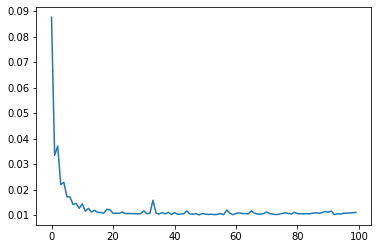

In [29]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=70
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=256


kospi=StockData(
    'temporature/sample',
    'temporature/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    

result_dic={}
evalution_costplt=[]    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

In [30]:
class StockData():
    """
        훈련용 데이터세트와 평가용 데이터세트를 만들기 위한 과정.

        파라미터:
            folderPath : 종목시장의 주가 csv가 저장되어있는 디렉토리 경로.
            indexPath : 종목시장의 인덱스 주 csv파일의 경로.
            timewindowsize : LSTM의 입력으로 들어가는 타임의 사이즈. 10일 경우 미래주가를 예측하기 위해 이전 10일 주가를 사용.
            windowsizeForPCC : PCC를 계산하기 위해 사용되는 타임의 사이즈. 10일 경우 관계주를 구하기 위해 이전 10일 주가를 사용.
            PositiveStockNumber : 긍정관계주 개수.
            NegativeStockNumber : 부정관계주 개수.
            train_test_rate : 훈련:평가 세트 비율. 0.7일 경우 생성된 데이터 세트중 70%는 훈련용, 30%는 평가용으로 사용.
            batchSize : 세트를 나누는 배치 사이즈.

        과정:
            종목시장의 모든 종목의 시가와 인덱스 시가를 읽어옴.
            minmax스케일러를 각 종목과 인덱스에 적용하고 저장.
            PCC계산, 관계주 계산.
            데이터세트 저장.
               
    """
    def __init__(self,folderPath,indexPath,timewindowsize,windowsizeForPCC,PostiveStockNumber,NegativeStockNumber,train_test_rate,batchSize):        
               
        if(train_test_rate<=0 or train_test_rate>=1):
            raise ValueError('train_test_rate should be between 0 and 1')        
        self.P=PostiveStockNumber
        self.N=NegativeStockNumber        
        self.T=timewindowsize
        self.Tr=windowsizeForPCC
        self.folderPath = folderPath      
        self.indexPath=indexPath    
        self.batchSize=batchSize
        self.date_duration=3000
        
        self.train_test_rate=train_test_rate
        self.scaler=MinMaxScaler(feature_range=(-1,1))  
        self.indexScaler = MinMaxScaler(feature_range=(-1,1))

        self.indexPrice = self.loadIndex()
        self.stockPrice = self.loadCSV()

        self.trainSet,self.testSet=self.make_dataset()

        self.batchNum={}
    
    def getBatch(self,option):
        """
        클래스에 저장된 세트를 y,xp,xn,xi,target으로 나누고 batch생성.

        args:
            option='training' or 'evaluation'

        returns:
            batch 제너레이터
            batch={'y','xp','xn','xi','target'}
        """
        if(option is not 'training' and option is not 'evaluation'):
            raise ValueError('option should be "training" or "evaluation".')

        if(option is 'training'):
            returnSet = self.trainSet
        else:
            returnSet = self.testSet
        
        y=[]
        xp=[]
        xn=[]
        xi=[]
        target=[]

        for d in returnSet:
            y.append(d['target_history'])  
            xp.append(d['pos_history'])       
            xn.append(d['neg_history'])       
            xi.append(d['index_history'])       
            target.append(d['target_price'])             
        y=np.reshape(y,(-1,self.T,1))
        xp=np.reshape(xp,(-1,15,self.T,1))
        xn=np.reshape(xn,(-1,15,self.T,1))
        xi=np.reshape(xi,(-1,self.T,1))
        target=np.reshape(target,(-1,1))

        print(y.shape,xp.shape,xn.shape,xi.shape,target.shape)     

        batchNum=int(len(y)/self.batchSize)
        self.batchNum[option]=batchNum

        for i in range(batchNum):
            yield {'y':y[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xp':xp[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xn':xn[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xi':xi[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'target':target[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32)}

    def loadCSV(self):
        """
        csv파일이 있는 폴더를 입력으로 받아 데이터를 읽어옴.
        """
        csvList=os.listdir(self.folderPath)        
        dataframe = pd.DataFrame([])
        

        for csv in csvList:
            data=pd.read_csv(self.folderPath+'/'+csv,engine='python')
            if(len(data)>self.date_duration):
                data=data[-self.date_duration-1:-1]
                data=data.reset_index()
                data=data['open']

                dataframe=dataframe.append(data,ignore_index=True)
        dataT=np.array(dataframe).T
        self.scaler.fit(dataT)
        dataT=self.scaler.transform(dataT)
        dataT=dataT.T
        dataframe=pd.DataFrame(dataT)
        dataframe=dataframe.transpose()
        print('StockPrice shape: ',dataframe.shape)
        return dataframe
    
    def loadIndex(self):
        data=pd.read_csv(self.indexPath,engine='python')
        data=data[-self.date_duration-1:-1]        
        data=data.reset_index()
        data=data.fillna(method='ffill')

        data=np.array(data['Open'])
        data=np.reshape(data,(-1,1))

        data=self.indexScaler.fit_transform(data)

        data=pd.DataFrame(np.squeeze(data))        

        print('IndexPrice shape: ',data.shape)
        return data 


    def make_dataset(self):
        """
        예측모델에 사용되는 입력,타겟 데이터세트.
        입력데이터의 shape는 (목표주식+관계주식+인덱스, 타임윈도우사이즈)
        타겟데이터의 shape는 (1,1)
        """
        maxday=max([self.T,self.Tr])
        dataset=[]

        for i in range(maxday,len(self.stockPrice)):
            print('making dataset progress : {}/{}'.format(i,len(self.stockPrice)),end='\r')
            priceSet=self.stockPrice.loc[i-self.T:i-1]
            targetSet=self.stockPrice.loc[i]
            positiveSet,negativeSet=self.calculate_correlation(self.stockPrice.loc[i-maxday:i-1])
            indexSet = self.indexPrice.loc[i-self.T:i-1]

            for targetNum in priceSet.columns:
                target_history=np.reshape(np.array(priceSet[targetNum]),(self.T,1))
                pos_history=np.reshape(np.array(positiveSet[targetNum].T),(15,self.T,1))
                neg_history=np.reshape(np.array(negativeSet[targetNum].T),(15,self.T,1))
                index_history=np.reshape(np.array(indexSet),(self.T,1))
                target_price=np.reshape(np.array(targetSet[targetNum]),(1,1))

                dataset.append({'target_history':target_history,
                                'pos_history':pos_history,
                                'neg_history':neg_history,
                                'index_history':index_history,
                                'target_price':target_price
                            })
        print('making dataset progress : finished\t')
        
        return dataset[:int(len(dataset)*self.train_test_rate)],dataset[int(len(dataset)*self.train_test_rate):]

    def calculate_correlation(self,priceSet):
        """
        Pearson Correlation Coefficient(PCC)를 계산하고,
        높은순으로 긍정관계주, 낮은순으로 부정관계주를 설정한 개수만큼 생성하여 리스트에 저장한후, 리턴.
        입력은 전체 종목의 타임윈도우간의 주가.

        Returns:
            #모든종목의 관계주. 
            긍정관계주 shape = (종목 수, dataframe(T*P))
            부정관계주 shape = (종목 수, dataframe(T*N))
        """    
        positive=[]
        negative=[] 
        corr=priceSet[-self.Tr:].corr(method='pearson')

        for i in corr.columns:
            tempCorr=corr[i].sort_values(ascending=False)
            index_P=tempCorr[1:self.P+1].index
            index_N=tempCorr[-self.N:].index
            
            priceSet=priceSet[-self.T:]
            posSet=priceSet[index_P]
            negSet=priceSet[index_N]
            posSet.columns=range(self.P)
            negSet.columns=range(self.N)
            
            positive.append(posSet)
            negative.append(negSet)
        return positive,negative

            
"""testLine
kospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)
print(np.shape(kospi.trainSet))
print(np.shape(kospi.testSet))
"""


"testLine\nkospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)\nprint(np.shape(kospi.trainSet))\nprint(np.shape(kospi.testSet))\n"

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 32, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f7c407e6e10>
Y_2 =  (None, 32, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7a3cf11390>, <gast.gast.Return object at 0x7f7a3cf11850>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7a3cf11390>, <gast.gast.Return object at 0x7f7a3cf11850>]
inputs :  Tensor("rnn_32/transpose_1:0", shape=(None, 32, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 32), dtype=float32)
enco

(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.7678570637945086
0.3115584321785718
epoch : 22, t_cost : 0.011998, e_cost : 0.011539, elapsed time : 29.10sec
(32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.7648460431955755
0.3083629033062607
epoch : 23, t_cost : 0.011951, e_cost : 0.011421, elapsed time : 29.09sec
(32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.7619267913978547
0.3066102445591241
epoch : 24, t_cost : 0.011905, e_cost : 0.011356, elapsed time : 29.06sec
(32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.759891914203763
0.3034665093291551
epoch : 25, t_cost : 0.011873, e_cost : 0.011240, elapsed time : 29.06sec


(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.6790734787937254
0.2895881764125079
epoch : 53, t_cost : 0.010611, e_cost : 0.010725, elapsed time : 29.09sec
(32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.6803419734351337
0.29203822708223015
epoch : 54, t_cost : 0.010630, e_cost : 0.010816, elapsed time : 29.12sec
(32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.6766380649060011
0.28955152665730566
epoch : 55, t_cost : 0.010572, e_cost : 0.010724, elapsed time : 29.09sec
(32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.6726736850105226
0.2935991492122412
epoch : 56, t_cost : 0.010511, e_cost : 0.010874, elapsed time : 29.07s

(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.6175754846772179
0.2736757736420259
epoch : 84, t_cost : 0.009650, e_cost : 0.010136, elapsed time : 29.08sec
(32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.6183982979273424
0.27475076797418296
epoch : 85, t_cost : 0.009662, e_cost : 0.010176, elapsed time : 29.09sec
(32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.6068151731742546
0.28134328522719443
epoch : 86, t_cost : 0.009481, e_cost : 0.010420, elapsed time : 29.10sec
(32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.6235271499026567
0.27919869928155094
epoch : 87, t_cost : 0.009743, e_cost : 0.010341, elapsed time : 29.08

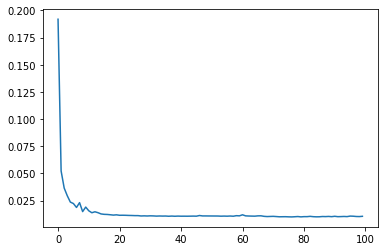

In [31]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'temporature/sample',
    'temporature/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    

result_dic={}
evalution_costplt=[]    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 32, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f7a44469190>
Y_2 =  (None, 32, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7da4bf2d50>, <gast.gast.Return object at 0x7f7da4bf2f10>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7da4bf2d50>, <gast.gast.Return object at 0x7f7da4bf2f10>]
inputs :  Tensor("rnn_32/transpose_1:0", shape=(None, 32, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 32), dtype=float32)
enco

(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.7802092605270445
0.3037027483806014
epoch : 22, t_cost : 0.012191, e_cost : 0.011248, elapsed time : 29.15sec
(32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.7677464806474745
0.3050992297939956
epoch : 23, t_cost : 0.011996, e_cost : 0.011300, elapsed time : 29.11sec
(32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.8100729142315686
0.30188306351192296
epoch : 24, t_cost : 0.012657, e_cost : 0.011181, elapsed time : 29.10sec
(32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.7734595772344619
0.3037188025191426
epoch : 25, t_cost : 0.012085, e_cost : 0.011249, elapsed time : 29.06se

(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.6950540640391409
0.2849203903460875
epoch : 53, t_cost : 0.010860, e_cost : 0.010553, elapsed time : 29.07sec
(32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.692403543042019
0.28398966952227056
epoch : 54, t_cost : 0.010819, e_cost : 0.010518, elapsed time : 29.12sec
(32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.689840676728636
0.28350982116535306
epoch : 55, t_cost : 0.010779, e_cost : 0.010500, elapsed time : 29.08sec
(32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.6871334202587605
0.28312574489973485
epoch : 56, t_cost : 0.010736, e_cost : 0.010486, elapsed time : 29.07se

(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.6356701066251844
0.28285589278675616
epoch : 84, t_cost : 0.009932, e_cost : 0.010476, elapsed time : 29.09sec
(32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.7687617116607726
0.293523772386834
epoch : 85, t_cost : 0.012012, e_cost : 0.010871, elapsed time : 29.05sec
(32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.7762504550628364
0.27720297046471387
epoch : 86, t_cost : 0.012129, e_cost : 0.010267, elapsed time : 29.06sec
(32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.6483322156127542
0.28497025731485337
epoch : 87, t_cost : 0.010130, e_cost : 0.010554, elapsed time : 29.13s

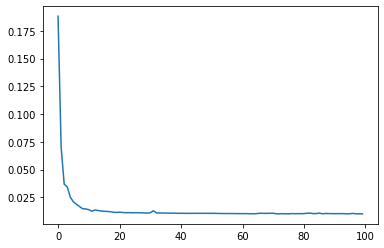

In [32]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'temporature/sample',
    'temporature/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    

result_dic={}
evalution_costplt=[]    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

In [ ]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'temporature/sample',
    'temporature/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    

result_dic={}
evalution_costplt=[]    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 32, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f7a155b8ad0>
Y_2 =  (None, 32, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7a24933f10>, <gast.gast.Return object at 0x7f7a24933150>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7a24933f10>, <gast.gast.Return object at 0x7f7a24933150>]
inputs :  Tensor("rnn_32/transpose_1:0", shape=(None, 32, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 32), dtype=float32)
enco

(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.7685432592406869
0.3010466599371284
epoch : 22, t_cost : 0.012008, e_cost : 0.011150, elapsed time : 29.16sec
(32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.7860285548958927
0.29622561554424465
epoch : 23, t_cost : 0.012282, e_cost : 0.010971, elapsed time : 29.06sec
(32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.8071501664817333
0.2957388188224286
epoch : 24, t_cost : 0.012612, e_cost : 0.010953, elapsed time : 29.09sec
(32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
(14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
0.7364986657630652
0.2930928207933903
epoch : 25, t_cost : 0.011508, e_cost : 0.010855, elapsed time : 29.16se

In [ ]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'temporature/sample',
    'temporature/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    

result_dic={}
evalution_costplt=[]    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

In [ ]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'temporature/sample',
    'temporature/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    

result_dic={}
evalution_costplt=[]    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

In [ ]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'temporature/sample',
    'temporature/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    

result_dic={}
evalution_costplt=[]    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

In [ ]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'temporature/sample',
    'temporature/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    

result_dic={}
evalution_costplt=[]    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

In [ ]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'temporature/sample',
    'temporature/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    

result_dic={}
evalution_costplt=[]    
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))